# PJM Western Hub Pricing Tool




### Username and Password for YES Energy

In [1]:
import my_secrets
username=my_secrets.username
password=my_secrets.password
#Username and password for DSAPI 

### Required libraries

In [2]:

#import required libraries
import pandas as pd
import numpy as np
import requests # Establishes connection to DSAPI to get data
import datetime
from datetime import datetime, timedelta, date 
import holidays
import lxml

#modeling
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.preprocessing import QuantileTransformer,StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid, GridSearchCV
import xgboost 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# testing 
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

#visualizations
import matplotlib.pyplot as plt 
import matplotlib.dates as md
import matplotlib.patches as mpatches
import seaborn as sns

In [26]:
pd.options.mode.chained_assignment = None  # default='warn'

### Data Collection and Feature Engineering


In [3]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text) #read the DSAPI call

In [4]:
def peak(hour):
    '''Maps hour-ending value (1-24) to peaktype'''
    if hour >= 11 and hour <= 17:
        return "SUPER"
    elif (hour >=7 and hour <11)or(hour >17 and hour <=19):
        return "ON"
    else: 
        return "OFF"

def encode(data, col, max_val):
    '''Encodes categorical column as periodic sin/cos function'''
    data[col + '_sin'] = np.sin(2 * np.pi * data[col].astype('category').cat.codes/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col].astype('category').cat.codes/max_val)
    return data



In [113]:
def df_preprocessing(df):
    '''Apply data pre-processing to raw table from YESEnergy and return modified dataframe'''
    #Remove rows with NaN datetimes from the dataframe
    df.dropna(axis=0, subset=['DATETIME'], inplace=True)
    df.drop_duplicates(subset=['DATETIME'], inplace=True)
    #Convert datetime column to datetime object
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
   
    # Combine columns 7-13, all are nuclear plant capoff in the Southern Region
    df['SOUTHERN REGION (NRC_PLANT_CAPOFF)']=df.iloc[:, 7:13].sum(axis=1)
    # Remove columns 7-13
    df=df.drop(df.iloc[:,7:14],axis=1) 
  
    # Rename some columns for convenience
    df.rename(columns={'WESTERN HUB (RTLMP)': 'RTLMP',
                     'WESTERN HUB (DALMP)': 'DALMP',
                     'VA - Richmond/Byrd Field (WSI_TRADER_PRCP)': 'WSI_TRADER_PRCP',
                     'VA - Richmond/Byrd Field (WSI_TRADER_CLDC)': 'WSI_TRADER_CLDC',
                     'VA - Richmond/Byrd Field (WSI_TRADER_TEMP)': 'WSI_TRADER_TEMP',
                     'VA - Richmond/Byrd Field (WSI_TRADER_WIND)': 'WSI_TRADER_WIND',
                     'VA - Richmond/Byrd Field (WSI_TRADER_RH)': 'WSI_TRADER_RH',
                     'VA - Richmond/Byrd Field (WSI_FC15_TEMP)':'WSI_FC15_TEMP',
                     'VA - Richmond/Byrd Field (WSI_FC15_PRCP)': 'WSI_FC15_PRCP',
                     'VA - Richmond/Byrd Field (WSI_FC15_RH)':'WSI_FC15_RH',
                     'VA - Richmond/Byrd Field (WSI_FC15_CLDC)':'WSI_FC15_CLDC',
                     'VA - Richmond/Byrd Field (WSI_FC15_WIND)':'WSI_FC15_WIND', 
                     'RTO COMBINED (REG_TOTAL_GEN_OFFLINE_CAPACITY)' : 'RTO COMBINED (CAPOFF)',
                     'PJM Mid Atlantic Dominion (REG_TOTAL_GEN_OFFLINE_CAPACITY)':'Mid Atlantic Region (CAPOFF)'},
                   inplace = True)
   
    #make holiday flag column
    us_holidays=[]
    for holiday_date in holidays.US(years=np.arange(2018,2023)).items():
        us_holidays.append(str(holiday_date[0]))
    df['US Holiday']=[1 if str(val).split()[0] in us_holidays else 0 for val in df['DATETIME']]
   
    # Make weekend flag column
    df['Weekend'] = [1 if val.weekday()>=5 else 0 for val in df['DATETIME']]
    #OR weekend and holiday columns
    df["WEEKEND/HOLIDAY"] = df["Weekend"] | df["US Holiday"]
    #drop weekend and holiday columns
    df=df.drop(['Weekend','US Holiday'],axis=1) 
   
    #OFFPEAK: HE 19-7, ONPEAK: HE 7-11, HE 17-19, SUPERPEAK: HE 11-17
    df.HOURENDING=df.HOURENDING.astype(int)
    df['PEAKTYPE'] = df.apply(lambda row: peak(row['HOURENDING']), axis=1)
   
    #create a column with the season
    season_dict = {'JANUARY': 'Winter',
                'FEBRUARY': 'Winter',
                'MARCH': 'Spring', 
                'APRIL': 'Spring',
                'MAY': 'Spring',
                'JUNE': 'Summer',
                'JULY': 'Summer',
                'AUGUST': 'Summer',
                'SEPTEMBER': 'Fall',
                'OCTOBER': 'Fall',
                'NOVEMBER': 'Fall',
                'DECEMBER': 'Winter'}
    df['SEASON'] = df['MONTH'].apply(lambda x: season_dict[x])
    df['WEEKDAY']=pd.to_datetime(df['DATETIME']).dt.day_name()
    
    #Create cyclical encoding for calendar variables
    df = encode(df, 'HOURENDING', 24)
    df = encode(df, 'PEAKTYPE', 3)
    df = encode(df, 'SEASON', 4)
    df = encode(df, 'WEEKDAY', 7)
    df = encode(df, 'MONTH', 12)
    df=df.drop(['HOURENDING', 'MARKETDAY','PEAKTYPE'],axis=1) #drop columns after encoding them

    # replace NA values with 0 for CAPOFF features i.e. assume that if the offline capacity is NaN, there is no offline capacity
    df["RTO COMBINED (CAPOFF)"] = df["RTO COMBINED (CAPOFF)"].fillna(0)
    df["Mid Atlantic Region (CAPOFF)"] = df["Mid Atlantic Region (CAPOFF)"].fillna(0)
    df["SOUTHERN REGION (NRC_PLANT_CAPOFF)"] = df["SOUTHERN REGION (NRC_PLANT_CAPOFF)"].fillna(0)

    #create congestion column
    df["CONGESTION"] = df["MID-ATLANTIC REGION (RTLOAD)"]-df["SOUTHERN REGION (RTLOAD)"]
    #create congestion flag column
    df["SOUTH HIGHER"] = [0 if val >=20000 else 1 for val in df["CONGESTION"]]

    #Create groupings for the transmission outage flags
    df['CONASTON XFORMER OUT']=df.iloc[:,15:19].sum(axis=1).astype('bool')
    df['BRIGHTON XFORMER OUT']=df.iloc[:,21:24].sum(axis=1).astype('bool')
    df['WAUGHCHA XFORMER OUT']=df.iloc[:,38:42].sum(axis=1).astype('bool')
    df['WEST LINE OUT']=(df.iloc[:,12:15].sum(axis=1).astype('bool')|df.iloc[:,19:21].sum(axis=1).astype('bool'))
    df['EAST LINE OUT']=df.iloc[:,24:38].sum(axis=1).astype('bool')
    df=df.drop(df.iloc[:,12:42],axis=1) #drop the flag columns

    #create column of delta between the WSI and other forecast
    df['FC DELTA']=df['RTO COMBINED (WSI_LOAD_FC_LATEST)'].astype(float)-df['RTO COMBINED (LOAD_FORECAST)'].astype(float)
    df['FC DELTA SOUTH']=df['SOUTHERN REGION (WSI_LOAD_FC_LATEST)'].astype(float)-df['SOUTHERN REGION (LOAD_FORECAST)'].astype(float)
    #drop categorical columns that have been encoded
    df=df.drop(['MONTH', 'YEAR', 'SEASON', 'WEEKDAY'],axis=1)

  
    df= df.reset_index(drop=True)
    return df


In [6]:
df=df_preprocessing(dfs[0])

In [10]:
def makelags(s,lag=[1,25]):
    '''Return dataframe with lag columns for lag amounts defined by lag list'''
    new_dict={}
    for col_name in s:
        for l in lag:
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)
    return res.dropna()
    

In [108]:
def prepare_forecast(df):
    '''Function replaces relevant features with their forecasts in df. Source of forecasts can be specified.'''
    df=df.reset_index(drop=True)
    #assign load vars based on source
  
    df['RTO COMBINED (RTLOAD)'].fillna(df['RTO COMBINED (LOAD_FORECAST)'], inplace=True)
    df['MID-ATLANTIC REGION (RTLOAD)'].fillna(df['MID-ATLANTIC REGION (LOAD_FORECAST)'], inplace=True)
    df['SOUTHERN REGION (RTLOAD)'].fillna(df['SOUTHERN REGION (LOAD_FORECAST)'], inplace=True)
    
    df['WSI_TRADER_TEMP'].fillna(df['WSI_FC15_TEMP'], inplace=True)
    df['WSI_TRADER_PRCP'].fillna(df['WSI_FC15_PRCP'], inplace=True)
    df['WSI_TRADER_CLDC'].fillna(df['WSI_FC15_CLDC'], inplace=True)
    df['WSI_TRADER_RH'].fillna(df['WSI_FC15_RH'], inplace=True)
    df['WSI_TRADER_WIND'].fillna(df['WSI_FC15_WIND'], inplace=True)
    df['RTO COMBINED (ORIGINAL_SOLARFCST_HOURLY)'].fillna(0,inplace=True)	
    df['RTO COMBINED (BIDCLOSE_WINDDATA_STF)'].fillna(0, inplace=True)

    #use most recenet gas price as the forecast for now
    df['Dominion-South (GASPRICE)'].fillna(df.loc[df['RTLMP'].last_valid_index(),'Dominion-South (GASPRICE)'], inplace=True)

    #reassign congestion variable for values that were missing
    df['CONGESTION']=df["MID-ATLANTIC REGION (RTLOAD)"].astype(float)-df["SOUTHERN REGION (RTLOAD)"].astype(float)

    df=df.reset_index(drop=True)
    return df

In [109]:
#log transformations
def transform(x,df, var='RTLMP'):
    '''Return the log transformed version of dataframe column x, deal with negative values by translate entire column up by the minimum price.'''
    return np.log(x+1-min(df[var]))

def inverse_transform(x,df, var='RTLMP'):
    '''Inverse transformation of transform(x) function gets you back your original column values.'''
    return np.exp(x)-1+min(df[var])

In [8]:
df=prepare_forecast(df)

In [11]:
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['RTLMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)


In [12]:
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)

In [13]:
df.reset_index(drop=True, inplace=True)

In [133]:
def find_spikes(df,lag=24, thresh=3.5, influence=0.5):
    ''' See: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data
  This function locates real time spikes in the RTLMP variable
  1: Spike, 0: No Spike, -1: Negative Spike (Price Dip)
  Lag: size of rolling observation window
  Threshold: Spike threshold (scaled by standard deviation of observation window)
  Influence: Proxy for influence of past observations on current observation
  '''
    filteredY=df.RTLMP.iloc[:lag+1]
    df['PEAK']=0
    avgFilter=filteredY.mean()
    stdFilter=filteredY.std()

    for i in range(lag+1,len(df.RTLMP)):
        if (abs(df.RTLMP[i]-avgFilter)>thresh*stdFilter):
            if df.RTLMP[i]>avgFilter:
                df.PEAK[i]=1
            else:
                df.PEAK[i]=-1
            filteredY.at[i]=(influence * df.RTLMP[i]) + ((1-influence)*filteredY[i-1])
        else:
            df.PEAK[i]=0
            filteredY.at[i]=df.RTLMP[i]
      
        avgFilter=filteredY.iloc[i-lag+1:i].mean()
        stdFilter=filteredY.iloc[i-lag+1:i].std()


def find_spikes_dalmp(df,lag=24, thresh=3.5, influence=0.5):
    '''This is a refined version of find_spikes that uses the DALMP as a basis for spike definition'''
    filteredY=df.DALMP[:lag+1]
    df['PEAK_DALMP']=0
    avgFilter=filteredY.mean()
    stdFilter=filteredY.std()

    for i in range(lag+1,len(df.RTLMP)):
        if (abs(df.RTLMP[i]-avgFilter)>thresh*stdFilter):
            if df.RTLMP[i]>avgFilter:
                df.PEAK_DALMP[i]=1
            else:
                df.PEAK_DALMP[i]=-1
            filteredY.at[i]=(influence * df.DALMP[i]) + ((1-influence)*filteredY[i-1])
        else:
            df.PEAK_DALMP[i]=0
            filteredY.at[i]=df.DALMP[i]
      
        avgFilter=filteredY[i-lag+1:i].mean()
        stdFilter=filteredY[i-lag+1:i].std()


def find_spikes_fast(df, lag=24, thresh=3.5):
    '''This is a faster version of find_spikes with loop removed. This function does not contain the influence variable. '''
    df['avgFilter'] = df.RTLMP.rolling(lag, closed="left").mean()
    df['stdFilter'] = df.RTLMP.rolling(lag, closed="left").std()
    df['pos_peak'] = df.RTLMP - df.avgFilter.shift(1) > thresh * df.stdFilter.shift(1)
    df['neg_peak'] = (abs(df.avgFilter.shift(1) - df.RTLMP) >  thresh * df.stdFilter.shift(1)) & (df.avgFilter.shift(1)>df.RTLMP)
  
    df['PEAK_FAST'] = df.pos_peak.astype(int) - df.neg_peak.astype(int)
    df.drop(['avgFilter', 'stdFilter', 'pos_peak', 'neg_peak'], axis=1, inplace=True)

In [21]:
#Demonstration of functionality of all three spike functions
test_df = pd.DataFrame({'RTLMP':[1,2,3,1,2,4,3,1000,1,2,3,-1000,10000],'DALMP':[1,2,3,1,2,4,3,10,1,2,3,-1000,10000]})
find_spikes(test_df,lag=6,thresh=0.5,influence=1)
find_spikes_dalmp(test_df,lag=6,thresh=0.5,influence=1)
find_spikes_fast(test_df,lag=6,thresh=0.5)
print(test_df[['RTLMP','DALMP','PEAK','PEAK_DALMP', 'PEAK_FAST']].head(20))

    RTLMP  DALMP  PEAK  PEAK_DALMP  PEAK_FAST
0       1      1     0           0          0
1       2      2     0           0          0
2       3      3     0           0          0
3       1      1     0           0          0
4       2      2     0           0          0
5       4      4     0           0          0
6       3      3     0           0          0
7    1000     10     1           1          1
8       1      1    -1          -1         -1
9       2      2     0          -1          0
10      3      3     0           0          0
11  -1000  -1000    -1          -1         -1
12  10000  10000     1           1          1


### Model Performance for a Sample Week

In [27]:
#split into train and test
find_spikes(df, lag=6, thresh=1, influence=1)
X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['RTLMP'],df)  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)

In [28]:
#Train and make predictions using 3 different regressors
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df)

rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df)

lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df)


[10:56:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
#Classify Spikes
clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)


In [30]:
#Compile results into dataframe 

d={ "West Hub XGB PRICES": y_pred, 
   'West Hub rf Prices': y_pred_rf,
   'West Hub lm Prices': y_pred_lm,
   "Actuals": inverse_transform(y_test,df),
   "Spikes":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1)


In [31]:
def plot_fill(dt, flag, fill_color='red'):
    if flag==1:
        ax.axvspan(xmin=dt, xmax=dt+timedelta(hours=1),  facecolor=fill_color, alpha=0.15)
    

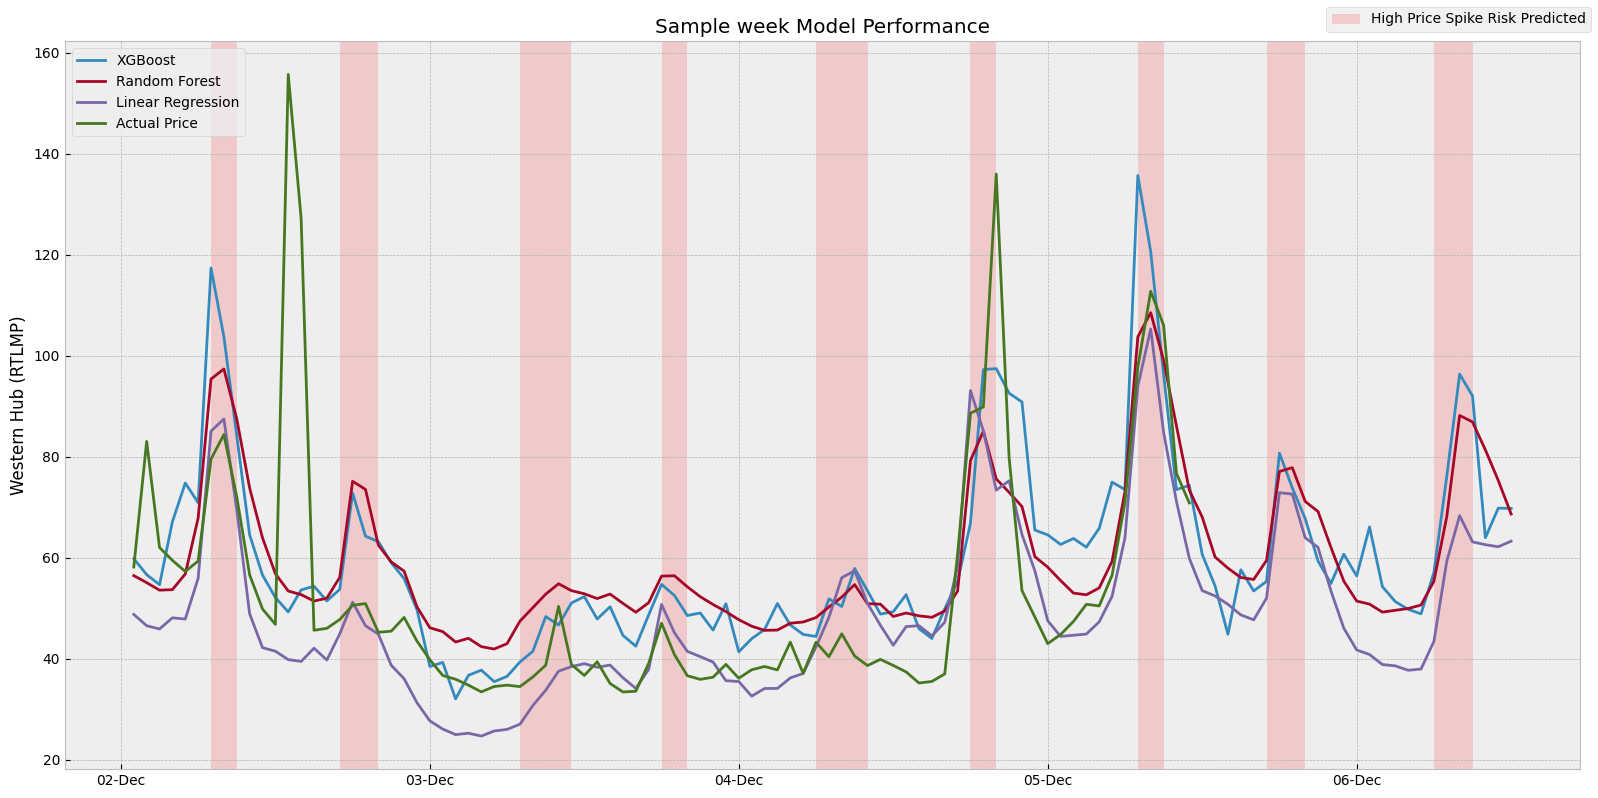

In [32]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)
dff['DATETIME']=pd.to_datetime(dff['DATETIME'])
xgbl,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost')
rf,=plt.plot(dff['DATETIME'], dff['West Hub rf Prices'], label='Random Forest')
lm,=plt.plot(dff['DATETIME'], dff['West Hub lm Prices'], label='Linear Regression')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual Price')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Model Performance")
ax.set_ylabel("Western Hub (RTLMP)")

dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,rf,lm,actuals],loc='upper left')
plt.show()

### Train Model on Spike Events Only

What would be the effect on our regressors of training the model during high price hours only?

In [51]:
df['SPIKE']=df['PEAK']
dfs=makelags(df[['SPIKE']],lag=[1,2,-1,-2])
dfs.iloc[:,:]=dfs.iloc[:,:].astype(bool)
dfs['SPIKE plus minus 2']=dfs['SPIKE_lag1'] | dfs['SPIKE_lag2'] |  dfs['SPIKE_lag-1'] | dfs['SPIKE_lag-2'] 
#make a separate training df with only spike data

df_train=pd.concat([X_train, inverse_transform(y_train, df), y2_train], axis=1).reset_index(drop=True)
df_train=pd.concat([df_train, dfs['SPIKE plus minus 2']],axis=1).reset_index(drop=True)
df_train['SPIKE plus minus 2'].fillna(True, inplace=True)
df_train.dropna(inplace=True, axis=0)
df_train=df_train[df_train['SPIKE plus minus 2']==True]

In [52]:
#split into train and test
X_train2=df_train.iloc[:,:-3].astype(float).reset_index(drop=True) #all columns except y variables and DATETIME column
y_train2 = df_train['RTLMP'].reset_index(drop=True)  # what we are trying to predict

xgb_model3 = xgboost.XGBRegressor(objective="reg:linear")
xgb_model3.fit(X_train2, y_train2)
y_pred_spikefull = xgb_model3.predict(X_test)




[11:51:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
d2={ "West Hub XGB PRICES": y_pred, 
     "Actuals": inverse_transform(y_test,df),
     "Trained on Spikes": y_pred_spikefull,
     "Spikes":spike_pred
   }
res=pd.DataFrame(d2)
dff2=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1)

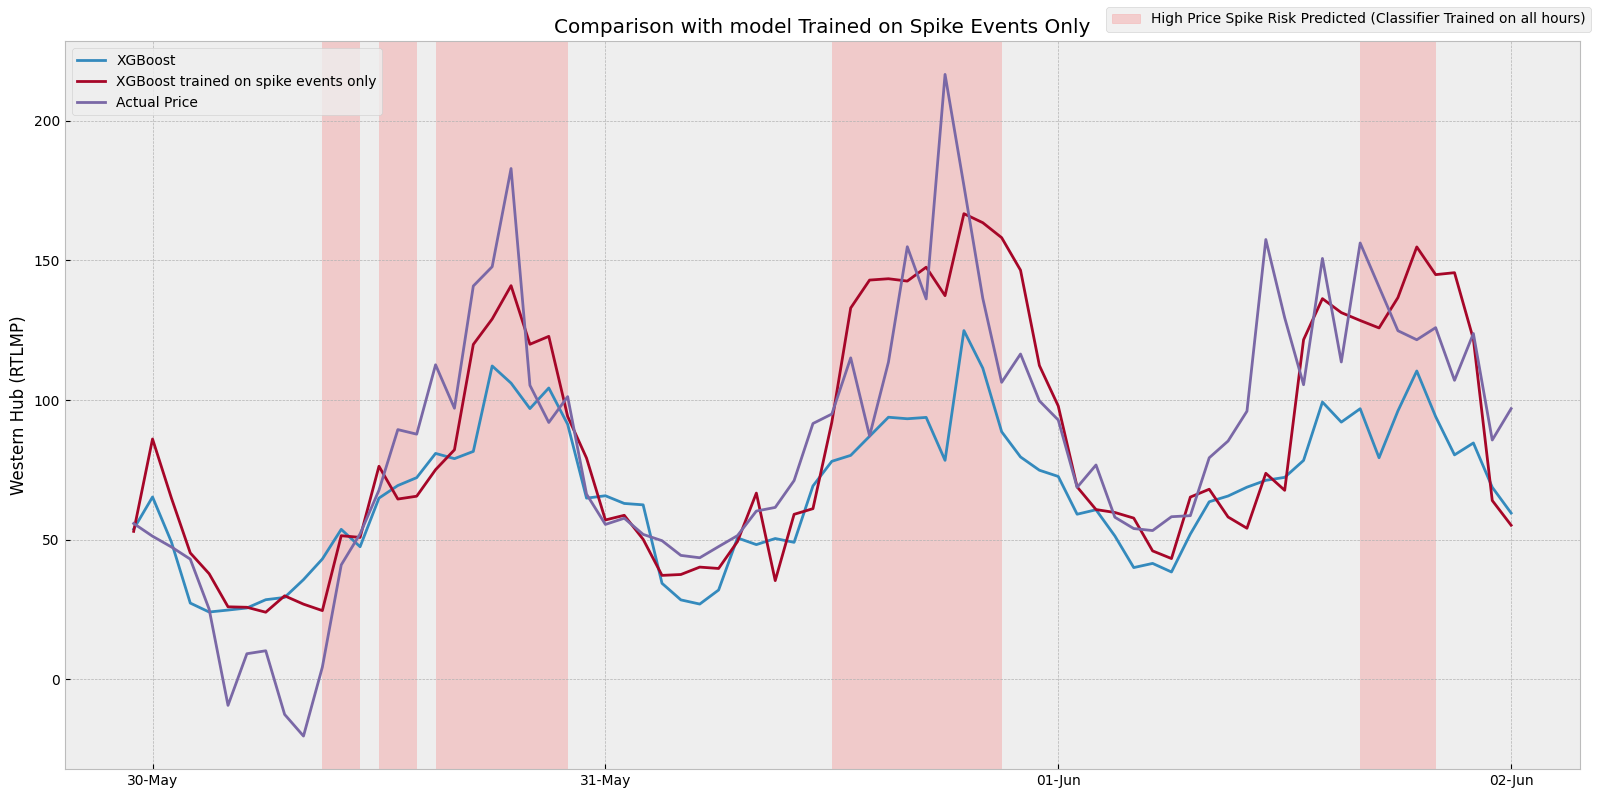

In [54]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)
dff2['DATETIME']=pd.to_datetime(dff2['DATETIME'])
xgbl,=plt.plot(dff2['DATETIME'], dff2['West Hub XGB PRICES'], label='XGBoost')
xgbl2,=plt.plot(dff2['DATETIME'], dff2['Trained on Spikes'], label='XGBoost trained on spike events only')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual Price')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Comparison with model Trained on Spike Events Only")
ax.set_ylabel("Western Hub (RTLMP)")

dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High Price Spike Risk Predicted (Classifier Trained on all hours)')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,xgbl2,actuals],loc='upper left')
plt.show()

### Demonstrate Model Performance with Sample Week in Different Month

In [39]:
user_auth = (username, password)
#Modify start date and end date in PJM_bookmark to get required date range
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate=2022-04-01&enddate=2022-06-01&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,DALMP:51288,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call

In [40]:
df=df_preprocessing(dfs[0])

In [41]:
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['RTLMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)


In [42]:
#RTLMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['RTLMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)

In [43]:
df.reset_index(drop=True, inplace=True)

In [45]:
find_spikes(df,lag=5,thresh=2.5,influence=0.5)

In [46]:
#split into train and test
X=df.iloc[:,2:-1].astype(float) #all columns except y variables and DATETIME column
y = transform(df['RTLMP'],df)  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)


In [47]:
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df)

rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df)

lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df)

clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)

[11:29:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
d={ "West Hub XGB PRICES": y_pred, 
   'West Hub rf Prices': y_pred_rf,
   'West Hub lm Prices': y_pred_lm,
   "Actuals": inverse_transform(y_test,df),
   "Spikes":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1)

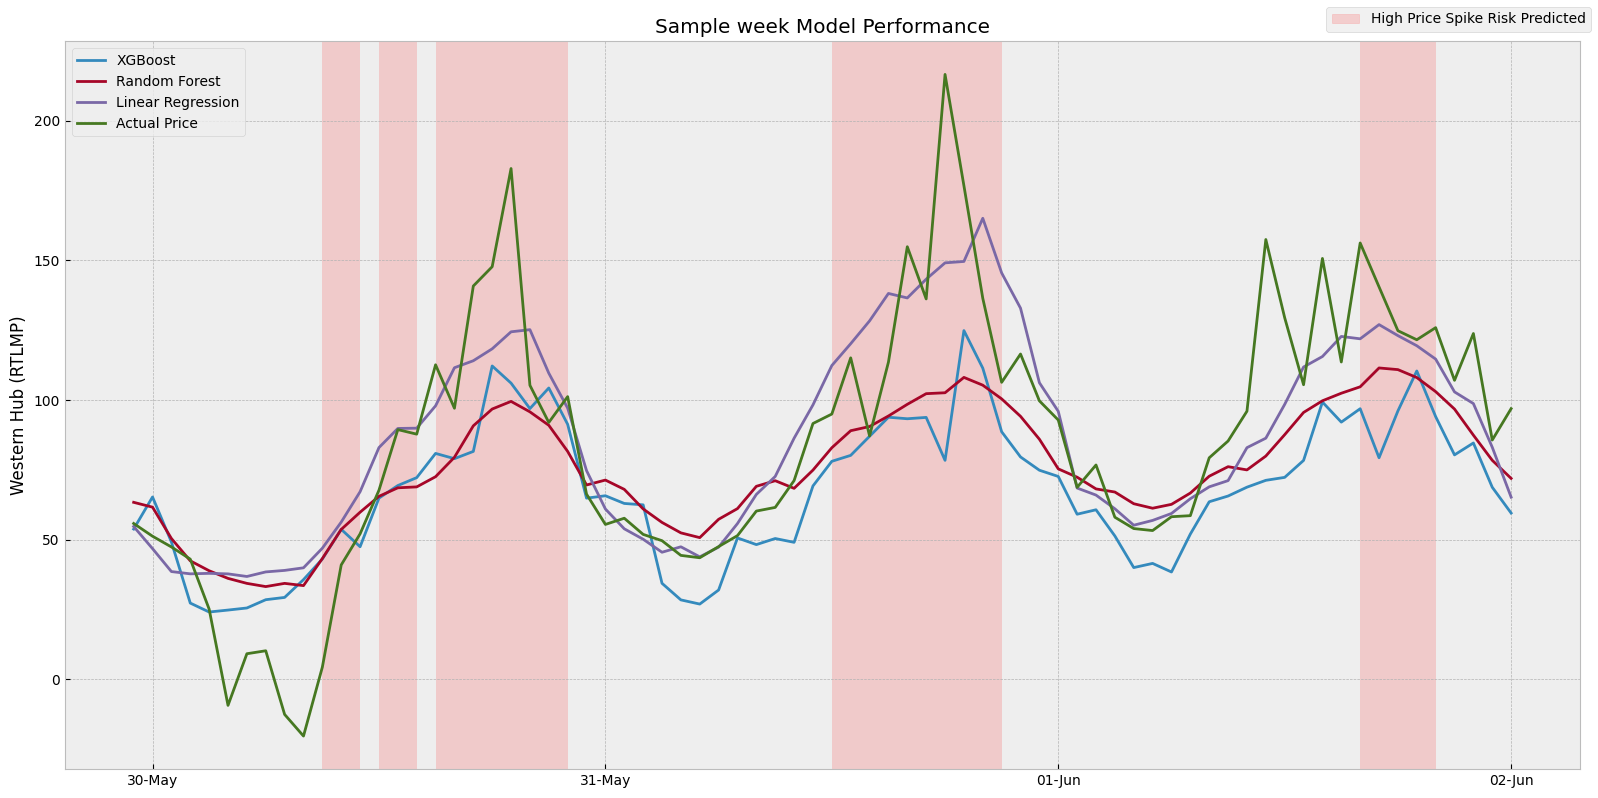

In [49]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)
dff['DATETIME']=pd.to_datetime(dff['DATETIME'])
xgbl,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost')
rf,=plt.plot(dff['DATETIME'], dff['West Hub rf Prices'], label='Random Forest')
lm,=plt.plot(dff['DATETIME'], dff['West Hub lm Prices'], label='Linear Regression')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual Price')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Model Performance")
ax.set_ylabel("Western Hub (RTLMP)")

dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,rf,lm,actuals],loc='upper left')
plt.show()

### Training/Testing Regression Models on DALMP (instead of DALMP)

The advantage of doing this is that the DALMP variable is less volatile, and will be easier to predict. Spike Predictions will still be made for the real time price. 


In [55]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&datecollections=4743858,102523&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,DALMP:51288,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call

In [56]:
df=df_preprocessing(dfs[0])

In [57]:
df=prepare_forecast(df)

In [58]:
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)


In [60]:
find_spikes(df,lag=6,thresh=1.5,influence=0.25)

In [61]:
#DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop(['RTLMP',
         'MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)

In [62]:
df.reset_index(drop=True, inplace=True)

In [63]:
#split into train and test
X=df.drop(['DATETIME','PEAK','DALMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
y = transform(df['DALMP'],df,'DALMP')  # what we are trying to predict
y2=df['PEAK']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False
)

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)


In [64]:
xgb_model = xgboost.XGBRegressor(objective="reg:linear")
xgb_model.fit(X_train, y_train)
y_pred = inverse_transform(xgb_model.predict(X_test),df,'DALMP')


[12:00:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt',n_jobs=-1)
rf.fit(X_train, y_train)  # apply scaling on training data
y_pred_rf = inverse_transform(rf.predict(X_test),df,'DALMP')

lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm=inverse_transform(lm.predict(X_test), df,'DALMP')

In [66]:
clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)

In [67]:
#Assemble results into dataframe
d={ "West Hub XGB PRICES": y_pred, 
    "West Hub rf Prices": y_pred_rf,
    "West Hub lm Prices": y_pred_lm,
    "Actuals": inverse_transform(y_test,df,'DALMP'),
    "Spikes":spike_pred,
   }
res=pd.DataFrame(d)
dff=pd.concat([X_test, res, df['DATETIME'][-len(res):]], axis=1)

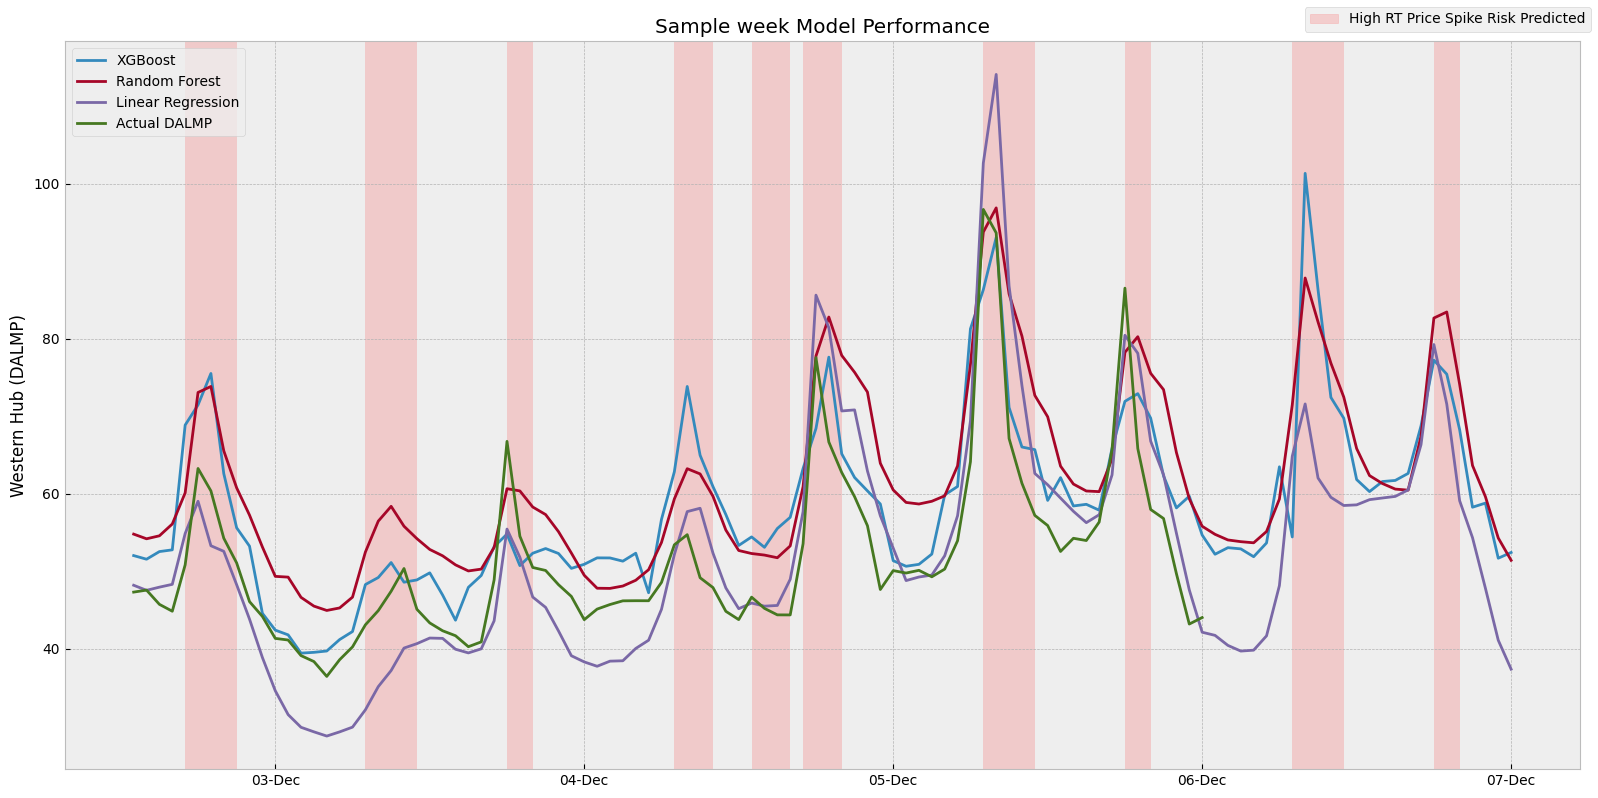

In [68]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)
dff['DATETIME']=pd.to_datetime(dff['DATETIME'])
xgbl,=plt.plot(dff['DATETIME'], dff['West Hub XGB PRICES'], label='XGBoost')
rf,=plt.plot(dff['DATETIME'], dff['West Hub rf Prices'], label='Random Forest')
lm,=plt.plot(dff['DATETIME'], dff['West Hub lm Prices'], label='Linear Regression')
actuals,=plt.plot(dff['DATETIME'], dff['Actuals'], label='Actual DALMP')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Sample week Model Performance")
ax.set_ylabel("Western Hub (DALMP)")

dff.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[xgbl,rf,lm,actuals],loc='upper left')
plt.show()

### PnL (Unit) Backtest

The metric used to evaluate the spike prediction model is PnL gained if the model is used. \
A dummy volume of 10 MW is used. The PnL calculations are very wonky in the case of the Western Hub as generation volume data isn't available. To be frank, what we are calculating here isn't really PnL, its just a method of quantifying and comparing the performance of our real time spike predictions. 
The following 2 strategies will be used to compute PnL:
1. Sell DA, buy in RT
2. Sell RT, buy DA
3. Sell in RT during red zones (spikes) only. Do option 1 during white zones. \
In reality, you should be doing nothing during red zones (not buying DA).

In [84]:
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate=2022-04-01&enddate=2022-06-01&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,DALMP:51288,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call

In [85]:
df=df_preprocessing(dfs[0])
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)

df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)


In [86]:
Lag=6
Threshold=1.5
Influence=0.25
find_spikes(df,lag=Lag,thresh=Threshold,influence=Influence)

In [87]:
#DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop([
         'MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
df.reset_index(drop=True, inplace=True)

In [88]:
#train model
X=df.drop(['DATETIME','PEAK','DALMP', 'RTLMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
y2=df['PEAK']

X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
)

clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
clf.fit(X_train, y2_train)
spike_pred=clf.predict(X_test)

In [89]:
Volume=10 #MW
d={ "DATETIME": df['DATETIME'][-len(spike_pred):], 
    "DALMP": df['DALMP'][-len(spike_pred):],
    "RTLMP": df['RTLMP'][-len(spike_pred):],
    "Spikes":spike_pred,
    "PnL: Sell DA": Volume*(df['DALMP'][-len(spike_pred):]-df['RTLMP'][-len(spike_pred):]),
    "PnL: Sell RT": Volume*(df['RTLMP'][-len(spike_pred):]-df['DALMP'][-len(spike_pred):])
   }
res=pd.DataFrame(d)
res=res.reset_index(drop=True)
#if spike predicted, sell DA
res['PnL: Spike'] = np.where((res['Spikes']) == 1,res['PnL: Sell RT'], res['PnL: Sell DA'])
res

,DATETIME,DALMP,RTLMP,Spikes,PnL: Sell DA,PnL: Sell RT,PnL: Spike
0,2022-05-29 23:00:00,66.495205,55.811655,-1,106.83550,-106.83550,106.83550
1,2022-05-30 00:00:00,63.745414,51.244581,-1,125.00833,-125.00833,125.00833
2,2022-05-30 01:00:00,51.498123,47.404608,-1,40.93515,-40.93515,40.93515
3,2022-05-30 02:00:00,49.155415,43.040268,-1,61.15147,-61.15147,61.15147
4,2022-05-30 03:00:00,48.197915,25.155008,-1,230.42907,-230.42907,230.42907
...,...,...,...,...,...,...,...
69,2022-06-01 20:00:00,111.256965,125.918922,1,-146.61957,146.61957,146.61957
70,2022-06-01 21:00:00,103.036864,107.051044,0,-40.14180,40.14180,-40.14180
71,2022-06-01 22:00:00,99.207593,123.815562,0,-246.07969,246.07969,-246.07969
72,2022-06-01 23:00:00,84.740720,85.679660,0,-9.38940,9.38940,-9.38940


In [90]:
print("-----------PnL Unit Backtest Results------------")
print("Start Date: " + str(res.loc[0, 'DATETIME'].date()))
print("End Date: " + str(res.loc[len(res)-1,'DATETIME'].date()))
print("Volume: "+str(Volume)+"MW\tLag: "+str(Lag)+"\tThreshold: "+str(Threshold)+"\tInfluence: "+str(Influence))
print("Total PnL, sell DA buy RT:          "+str(res['PnL: Sell DA'].sum()))
print("Total PnL, sell RT buy DA:          "+str(res['PnL: Sell RT'].sum()))
print("Total PnL, using Spike Predictions: "+str(res['PnL: Spike'].sum()))

-----------PnL Unit Backtest Results------------
Start Date: 2022-05-29
End Date: 2022-06-02
Volume: 10MW	Lag: 6	Threshold: 1.5	Influence: 0.25
Total PnL, sell DA buy RT:          3624.2269699999993
Total PnL, sell RT buy DA:          -3624.2269699999993
Total PnL, using Spike Predictions: 1595.801090000001


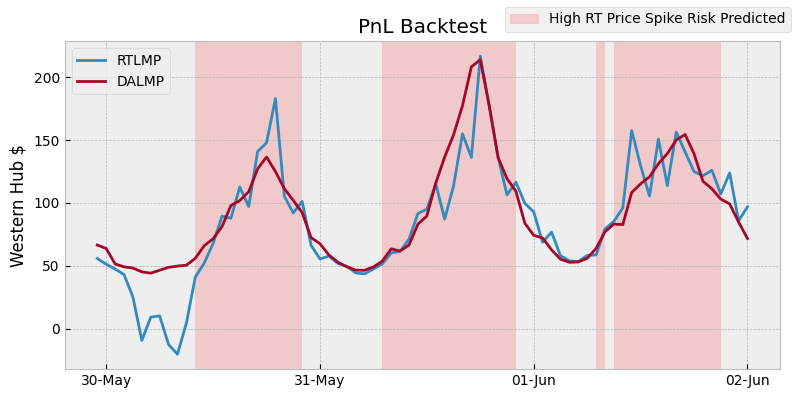

In [91]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (8, 4),tight_layout=True)
res['DATETIME']=pd.to_datetime(res['DATETIME'])
rtlmp,=plt.plot(res['DATETIME'], res['RTLMP'], label='RTLMP')
dalmp,=plt.plot(res['DATETIME'], res['DALMP'], label='DALMP')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("PnL Backtest")
ax.set_ylabel("Western Hub $")

res.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch])
ax.legend(handles=[rtlmp,dalmp],loc='upper left')
plt.show()

### Define a function that performs a unit test

In [136]:
def pnl_test(Lag, Threshold, Influence, Vol=10):

    #Find Spikes in Training Set
    find_spikes(df,lag=Lag,thresh=Threshold,influence=Influence)
    
    df.reset_index(drop=True, inplace=True)
    #train model
    X=df.drop(['DATETIME','PEAK','DALMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
    y2=df['PEAK']

    X_train, X_test, y2_train, y2_test=train_test_split(
        X, y2, test_size=0.05, shuffle=False
    )

    clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
    clf.fit(X_train, y2_train)
    spike_pred=clf.predict(X_test)
  
    d={ 
      "DATETIME": df['DATETIME'][-len(spike_pred):], 
      "DALMP": df['DALMP'][-len(spike_pred):],
      "RTLMP": df['RTLMP'][-len(spike_pred):],
      "Spikes":spike_pred,
      "PnL: Sell DA": Vol*(df['DALMP'][-len(spike_pred):]-df['RTLMP'][-len(spike_pred):]),
      "PnL: Sell RT": Vol*(df['RTLMP'][-len(spike_pred):]-df['DALMP'][-len(spike_pred):])
        }
    res=pd.DataFrame(d)
    res=res.reset_index(drop=True)
    #if spike predicted, sell DA
    res['PnL: Spike'] = np.where((res['Spikes']) == 1,res['PnL: Sell RT'], res['PnL: Sell DA'])
    #return test results and res df (if you ever want to refer to it)
    return res['PnL: Spike'].sum(), res['PnL: Sell DA'].sum()



### PnL Backtests and Model Parameter Optimization

In [138]:
pd.options.mode.chained_assignment = None  # default='warn'
#Gather data and preprocess it one time only to save time 
user_auth = (username, password)
PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate=2022-04-01&enddate=2022-06-01&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,DALMP:51288,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'

dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
dfs = pd.read_html(dsapi_dalmp_call.text) #read the DSAPI call
df=df_preprocessing(dfs[0])
df=prepare_forecast(df)
#make a 25 hour RTLMP price lag (and for other vars also)
df_lags=makelags(df[['DALMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
#DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
#drop columns to decrease correlations
df.drop([
         'MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)

def objective(trial):
    Lag = trial.suggest_int("Lag", 24, 24*7*3, step=6)
    Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    Influence = trial.suggest_float("Influence", 0.0, 1.0)
    pnl_spike_sum, pnl_sell_da_sum = pnl_test(Lag, Threshold, Influence)
    #trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=100, n_jobs=-1)


[I 2022-12-05 13:42:20,344] A new study created in memory with name: no-name-ab320bcb-0148-4168-900a-21bb783d5b05
[I 2022-12-05 13:42:50,567] Trial 4 finished with value: 4497.7738899999995 and parameters: {'Lag': 318, 'Threshold': 2.5, 'Influence': 0.3611773086111054}. Best is trial 4 with value: 4497.7738899999995.
[I 2022-12-05 13:42:50,771] Trial 3 finished with value: 4820.656889999999 and parameters: {'Lag': 468, 'Threshold': 5.5, 'Influence': 0.22515159961846887}. Best is trial 3 with value: 4820.656889999999.
[I 2022-12-05 13:42:50,899] Trial 7 finished with value: 3624.2269699999993 and parameters: {'Lag': 480, 'Threshold': 3.0, 'Influence': 0.6195281980444443}. Best is trial 3 with value: 4820.656889999999.
[I 2022-12-05 13:42:50,955] Trial 0 finished with value: 4497.7738899999995 and parameters: {'Lag': 54, 'Threshold': 4.5, 'Influence': 0.896205106326143}. Best is trial 3 with value: 4820.656889999999.
[I 2022-12-05 13:42:55,801] Trial 5 finished with value: 3624.226969999

[I 2022-12-05 13:44:55,722] Trial 38 finished with value: 3781.6065700000004 and parameters: {'Lag': 24, 'Threshold': 1.5, 'Influence': 0.1295117091941722}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:45:04,237] Trial 39 finished with value: 4222.548170000001 and parameters: {'Lag': 444, 'Threshold': 1.5, 'Influence': 0.12744225161127798}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:45:07,324] Trial 40 finished with value: 4727.396570000002 and parameters: {'Lag': 426, 'Threshold': 1.5, 'Influence': 0.127524534702529}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:45:10,589] Trial 42 finished with value: 3620.242870000001 and parameters: {'Lag': 138, 'Threshold': 2.0, 'Influence': 0.13115707012710043}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:45:12,093] Trial 41 finished with value: 3620.242870000001 and parameters: {'Lag': 114, 'Threshold': 1.5, 'Influence': 0.11304301336017303}. Best is trial 34 with

[I 2022-12-05 13:47:15,290] Trial 76 finished with value: 5101.535470000002 and parameters: {'Lag': 432, 'Threshold': 5.5, 'Influence': 0.1977787272097003}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:47:15,542] Trial 78 finished with value: 4727.396570000002 and parameters: {'Lag': 270, 'Threshold': 1.0, 'Influence': 0.19203663212927954}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:47:15,674] Trial 77 finished with value: 4992.956870000001 and parameters: {'Lag': 264, 'Threshold': 6.5, 'Influence': 0.07738540184741988}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:47:25,066] Trial 79 finished with value: 4437.389230000002 and parameters: {'Lag': 426, 'Threshold': 1.0, 'Influence': 0.08083476766242605}. Best is trial 34 with value: 5442.065010000001.
[I 2022-12-05 13:47:30,136] Trial 80 finished with value: 4931.828590000001 and parameters: {'Lag': 132, 'Threshold': 1.0, 'Influence': 0.07676997494168898}. Best is trial 34 wi

In [139]:
study.best_trial

FrozenTrial(number=34, values=[5442.065010000001], datetime_start=datetime.datetime(2022, 12, 5, 13, 44, 10, 556078), datetime_complete=datetime.datetime(2022, 12, 5, 13, 44, 41, 193382), params={'Lag': 294, 'Threshold': 0.5, 'Influence': 0.779942541094533}, distributions={'Lag': IntDistribution(high=504, log=False, low=24, step=6), 'Threshold': FloatDistribution(high=7.5, log=False, low=0.5, step=0.5), 'Influence': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={'PnL: Sell DA': 3624.2269699999993}, system_attrs={}, intermediate_values={}, trial_id=34, state=TrialState.COMPLETE, value=None)

In [140]:
test1= study.trials_dataframe()

In [141]:
test1

,number,value,datetime_start,datetime_complete,duration,params_Influence,params_Lag,params_Threshold,user_attrs_PnL: Sell DA,state
0,0,4497.77389,2022-12-05 13:42:20.351266,2022-12-05 13:42:50.955489,0 days 00:00:30.604223,0.896205,54,4.5,3624.22697,COMPLETE
1,1,3624.22697,2022-12-05 13:42:20.420091,2022-12-05 13:43:04.664349,0 days 00:00:44.244258,0.240995,78,5.0,3624.22697,COMPLETE
2,2,3624.22697,2022-12-05 13:42:20.434090,2022-12-05 13:42:56.702350,0 days 00:00:36.268260,0.688998,144,3.5,3624.22697,COMPLETE
3,3,4820.65689,2022-12-05 13:42:20.535096,2022-12-05 13:42:50.771367,0 days 00:00:30.236271,0.225152,468,5.5,3624.22697,COMPLETE
4,4,4497.77389,2022-12-05 13:42:20.568099,2022-12-05 13:42:50.567241,0 days 00:00:29.999142,0.361177,318,2.5,3624.22697,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,4808.98927,2022-12-05 13:47:51.136514,2022-12-05 13:48:12.168499,0 days 00:00:21.031985,0.034277,192,0.5,3624.22697,COMPLETE
96,96,3624.22697,2022-12-05 13:47:54.645945,2022-12-05 13:48:10.506955,0 days 00:00:15.861010,0.011925,192,6.0,3624.22697,COMPLETE
97,97,3624.22697,2022-12-05 13:48:03.481099,2022-12-05 13:48:14.839262,0 days 00:00:11.358163,0.001110,504,6.0,3624.22697,COMPLETE
98,98,4835.97517,2022-12-05 13:48:03.894916,2022-12-05 13:48:15.006271,0 days 00:00:11.111355,0.875354,444,0.5,3624.22697,COMPLETE


C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

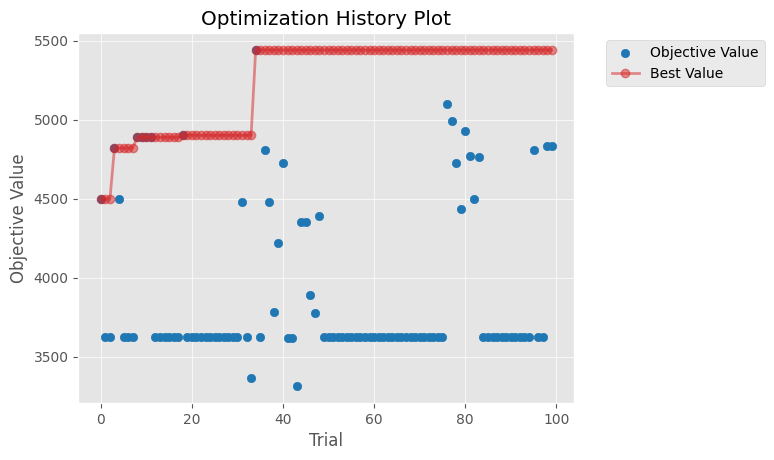

In [147]:
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\2367328650.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2022-12-05 14:19:05,311] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot:ylabel='Influence'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Lag'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='Influence', ylabel='Threshold'>,
        <AxesSubplot:xlabel='Lag'>, <AxesSubplot:xlabel='Threshold'>]],
      dtype=object)

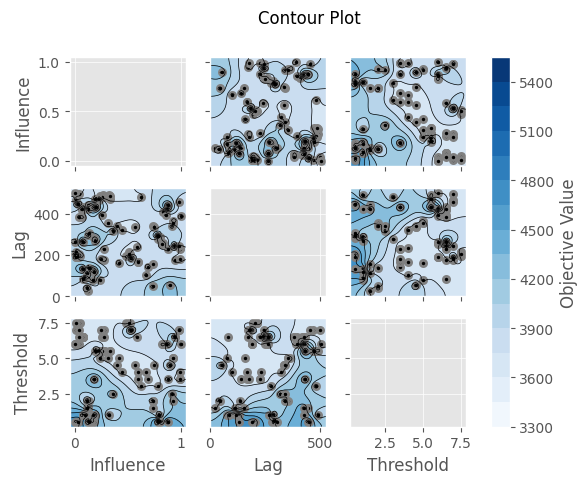

In [148]:
optuna.visualization.matplotlib.plot_contour(study)

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<AxesSubplot:xlabel='Influence', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='Lag'>, <AxesSubplot:xlabel='Threshold'>],
      dtype=object)

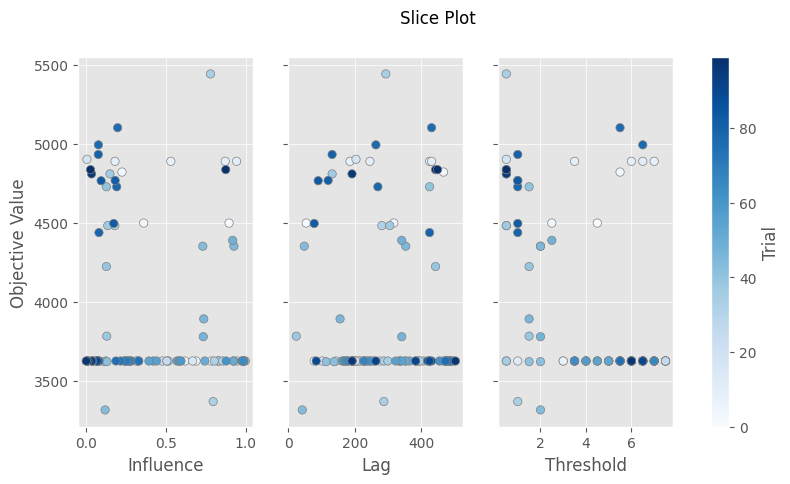

In [149]:
optuna.visualization.matplotlib.plot_slice(study)

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

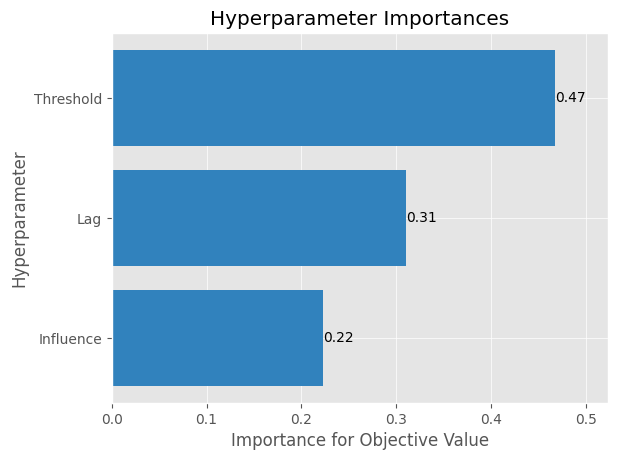

In [150]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [152]:
test1.to_csv("Testresults.csv")

In [161]:
def pnl_test_get_res(data,Lag, Threshold, Influence,start_date="2022-04-01", end_date="2022-06-01", Vol=10):
  df=df_preprocessing(data)
  df=prepare_forecast(df)
  mask = (df['DATETIME'] > start_date) & (df['DATETIME'] <= end_date)
  df = df.loc[mask]
  df.reset_index(drop=True, inplace=True)

  #make a 25 hour RTLMP price lag (and for other vars also)
  df_lags=makelags(df[['DALMP','RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']], lag=[25])
  df=pd.concat([df.reset_index(drop=True),df_lags],axis=1)
  df_lags=makelags(df[['RTO COMBINED (RTLOAD)', 'CONGESTION', 'WSI_TRADER_TEMP']],lag=[1])
  df=pd.concat([df.reset_index(drop=True), df_lags],axis=1)
  #Find Spikes in Training Set
  find_spikes_fast(df,lag=Lag,thresh=Threshold)
  #DALMP lag 25 will be the limiting feature that sets the range of datetimes used for training testing and validation
  df.dropna(axis=0,subset=['DALMP_lag25'], inplace=True)
  #drop columns to decrease correlations
  df.drop([
         'MID-ATLANTIC REGION (RTLOAD)', 
         'MID-ATLANTIC REGION (LOAD_FORECAST)',
         'SOUTHERN REGION (LOAD_FORECAST)',
         'RTO COMBINED (WSI_LOAD_FC_LATEST)', 
         'MID-ATLANTIC REGION (WSI_LOAD_FC_LATEST)',
         'SOUTHERN REGION (WSI_LOAD_FC_LATEST)',
         'RTO COMBINED (OS_TOTAL_SCHED_CAP)',
         'WSI_FC15_TEMP',
         'WSI_FC15_PRCP',
         'WSI_FC15_RH',
         'WSI_FC15_CLDC',
         'WSI_FC15_WIND'], 
          inplace=True, 
          axis=1)
  df.reset_index(drop=True, inplace=True)
  #train model
  X=df.drop(['DATETIME','PEAK_FAST','DALMP'],axis=1).astype(float) #all columns except y variables and DATETIME column
  y2=df['PEAK_FAST']

  X_train, X_test, y2_train, y2_test=train_test_split(
    X, y2, test_size=0.05, shuffle=False
  )

  clf=RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
  clf.fit(X_train, y2_train)
  spike_pred=clf.predict(X_test)
  
  d={ "DATETIME": df['DATETIME'][-len(spike_pred):], 
   'DALMP': df['DALMP'][-len(spike_pred):],
   'RTLMP': df['RTLMP'][-len(spike_pred):],
   'PEAK':df['PEAK_FAST'][-len(spike_pred):],
   "Spikes":spike_pred,
   "PnL: Sell DA": Vol*(df['DALMP'][-len(spike_pred):]-df['RTLMP'][-len(spike_pred):]),
   "PnL: Sell RT old": Vol*(df['RTLMP'][-len(spike_pred):]-df['DALMP'][-len(spike_pred):]),
   "PnL: Sell RT": Vol*(df['RTLMP'][-len(spike_pred):] ) 
   }
  res=pd.DataFrame(d)
  res=res.reset_index(drop=True)
  #if spike predicted, sell DA
  res['PnL: Spike'] = np.where((res['Spikes']) == 1,res['PnL: Sell RT old'], res['PnL: Sell DA'])
  #return test results and res df (if you ever want to refer to it)
  return res.drop(['PnL: Sell RT old'], axis=1) 

In [157]:
#Predownload some data for the entire past two years
user_auth = (username, password)
dates = pd.period_range(start='2021-01-01', end=date.today(),freq='M').strftime('%Y-%m-01')
data=pd.DataFrame()
for i in range (len(dates)-1): # Repeatedly call the DSAPI endpoint in html format
        start_dt = dates[i]
        end_dt = dates[i+1]
        print("Loading data... "+start_dt+"->"+end_dt)
        PJM_bookmark='https://services.yesenergy.com/PS/rest/timeseries/multiple.html?agglevel=hour&startdate={}&enddate={}&items=RTLMP:51288,RTLOAD:10000002572,RTLOAD:10000002596,RTLOAD:10000002574,REG_TOTAL_GEN_OFFLINE_CAPACITY:10000002572:today+48hours,REG_TOTAL_GEN_OFFLINE_CAPACITY:10002234378:today+48hours,NRC_PLANT_CAPOFF:10001867691,NRC_PLANT_CAPOFF:10001870755,NRC_PLANT_CAPOFF:10001870751,NRC_PLANT_CAPOFF:10001872506,NRC_PLANT_CAPOFF:10001872510,NRC_PLANT_CAPOFF:10001870210,NRC_PLANT_CAPOFF:10001870209,LOAD_FORECAST:10000002572:today+48hours,LOAD_FORECAST:10000002596:today+48hours,LOAD_FORECAST:10000002574:today+48hours,GASPRICE:10000002584,WSI_TRADER_TEMP:10000356906,ACTUALOUTAGES_COUNT:10002923086,ACTUALOUTAGES_COUNT:10002891887,ACTUALOUTAGES_COUNT:10000565663,ACTUALOUTAGES_COUNT:10000465786,ACTUALOUTAGES_COUNT:10000465784,ACTUALOUTAGES_COUNT:10000465785,ACTUALOUTAGES_COUNT:10000811365,ACTUALOUTAGES_COUNT:10002551925,ACTUALOUTAGES_COUNT:10002422457,ACTUALOUTAGES_COUNT:10000466312,ACTUALOUTAGES_COUNT:10000466313,ACTUALOUTAGES_COUNT:10000643497,ACTUALOUTAGES_COUNT:10000826306,ACTUALOUTAGES_COUNT:10000826072,ACTUALOUTAGES_COUNT:10002498463,ACTUALOUTAGES_COUNT:10002870484,ACTUALOUTAGES_COUNT:10000565751,ACTUALOUTAGES_COUNT:10000565752,ACTUALOUTAGES_COUNT:10000565753,ACTUALOUTAGES_COUNT:10000565754,ACTUALOUTAGES_COUNT:10000565660,ACTUALOUTAGES_COUNT:10000565661,ACTUALOUTAGES_COUNT:10000565710,ACTUALOUTAGES_COUNT:10000565785,ACTUALOUTAGES_COUNT:10016480695,ACTUALOUTAGES_COUNT:10016480693,ACTUALOUTAGES_COUNT:10000826204,ACTUALOUTAGES_COUNT:10000465968,ACTUALOUTAGES_COUNT:10000465969,ACTUALOUTAGES_COUNT:10000465970,WSI_TRADER_PRCP:10000356906,WSI_TRADER_CLDC:10000356906,WSI_TRADER_RH:10000356906,WSI_LOAD_FC_LATEST:10000002572:today+48hours,WSI_LOAD_FC_LATEST:10000002596:today+48hours,WSI_LOAD_FC_LATEST:10000002574:today+48hours,WSI_FC15_TEMP:10000356906:today+48hours,WSI_FC15_PRCP:10000356906:today+48hours,WSI_FC15_RH:10000356906:today+48hours,WSI_FC15_CLDC:10000356906:today+48hours,WSI_TRADER_WIND:10000356906,WSI_FC15_WIND:10000356906:today+48hours,DALMP:51288,ORIGINAL_SOLARFCST_HOURLY:10000002572,OS_TOTAL_SCHED_CAP:10000002572,BIDCLOSE_WINDDATA_STF:10000002572'.format(start_dt, end_dt)

        dsapi_dalmp_call = requests.get(PJM_bookmark,
                                auth=user_auth)
        dfs = pd.read_html(dsapi_dalmp_call.text, parse_dates=True) #read the DSAPI call
        data=pd.concat([data,dfs[0]]) #append html dataframe to the end of df


Loading data... 2021-01-01->2021-02-01
Loading data... 2021-02-01->2021-03-01
Loading data... 2021-03-01->2021-04-01
Loading data... 2021-04-01->2021-05-01
Loading data... 2021-05-01->2021-06-01
Loading data... 2021-06-01->2021-07-01
Loading data... 2021-07-01->2021-08-01
Loading data... 2021-08-01->2021-09-01
Loading data... 2021-09-01->2021-10-01
Loading data... 2021-10-01->2021-11-01
Loading data... 2021-11-01->2021-12-01
Loading data... 2021-12-01->2022-01-01
Loading data... 2022-01-01->2022-02-01
Loading data... 2022-02-01->2022-03-01
Loading data... 2022-03-01->2022-04-01
Loading data... 2022-04-01->2022-05-01
Loading data... 2022-05-01->2022-06-01
Loading data... 2022-06-01->2022-07-01
Loading data... 2022-07-01->2022-08-01
Loading data... 2022-08-01->2022-09-01
Loading data... 2022-09-01->2022-10-01
Loading data... 2022-10-01->2022-11-01
Loading data... 2022-11-01->2022-12-01


In [ ]:
res=pnl_test_get_res(data,294,0.5,0.77)

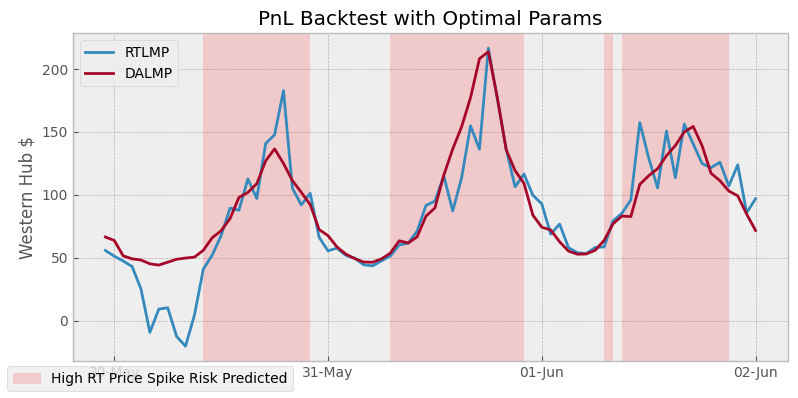

In [155]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (8, 4),tight_layout=True)
res['DATETIME']=pd.to_datetime(res['DATETIME'])
rtlmp,=plt.plot(res['DATETIME'], res['RTLMP'], label='RTLMP')
dalmp,=plt.plot(res['DATETIME'], res['DALMP'], label='DALMP')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("PnL Backtest with Optimal Params")
ax.set_ylabel("Western Hub $")

res.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[rtlmp,dalmp],loc='upper left')
plt.show()

### PnL BackTests and Model Param Optimization : Increased Date Range

In [ ]:
data.reset_index(inplace=True, drop=True)

In [ ]:
data.columns

Index(['DATETIME', 'RTLMP', 'RTO COMBINED (RTLOAD)',
       'SOUTHERN REGION (RTLOAD)', 'RTO COMBINED (CAPOFF)',
       'Mid Atlantic Region (CAPOFF)', 'RTO COMBINED (LOAD_FORECAST)',
       'Dominion-South (GASPRICE)', 'WSI_TRADER_TEMP', 'WSI_TRADER_PRCP',
       'WSI_TRADER_CLDC', 'WSI_TRADER_RH', 'WSI_TRADER_WIND', 'DALMP',
       'RTO COMBINED (ORIGINAL_SOLARFCST_HOURLY)',
       'RTO COMBINED (BIDCLOSE_WINDDATA_STF)',
       'SOUTHERN REGION (NRC_PLANT_CAPOFF)', 'WEEKEND/HOLIDAY',
       'HOURENDING_sin', 'HOURENDING_cos', 'PEAKTYPE_sin', 'PEAKTYPE_cos',
       'SEASON_sin', 'SEASON_cos', 'WEEKDAY_sin', 'WEEKDAY_cos', 'MONTH_sin',
       'MONTH_cos', 'CONGESTION', 'SOUTH HIGHER', 'CONASTON XFORMER OUT',
       'BRIGHTON XFORMER OUT', 'WAUGHCHA XFORMER OUT', 'WEST LINE OUT',
       'EAST LINE OUT', 'FC DELTA', 'FC DELTA SOUTH', 'DALMP_lag25',
       'RTO COMBINED (RTLOAD)_lag25', 'CONGESTION_lag25',
       'WSI_TRADER_TEMP_lag25', 'RTO COMBINED (RTLOAD)_lag1',
       'CONGESTION_la

In [158]:
def run_through_dates(data,Lag, Threshold, Influence, base):
    '''Get PnL BackTest Results for the entire date range from Jan 2021-today'''

    date_list = [str((pd.to_datetime(base) + timedelta(days=3*x)).date()) for x in range(10*9)] #10*3=30 days or one month worth of backtesting
    #initialize df
    df=pd.DataFrame()
    for start_dt in date_list:
        end_dt=str((pd.to_datetime(start_dt)+timedelta(days=2*30)).date())
        #call pnl test get res with start_dt and end_dt
        df_new=pnl_test_get_res(data,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, Vol=10)
        #concat dfs as you loop through
        df=pd.concat([df, df_new],axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [159]:
def my_scoring_func(data,Lag, Threshold, Influence, base='2022-01-01'):
    '''Function call run through dates and obtains resulting PnL for DA selling and spike methods'''
    res=run_through_dates(data,Lag, Threshold, Influence, base)
    #return res['PnL: Spike'].sum()
    return res['PnL: Spike'].sum(), res['PnL: Sell DA'].sum()


In [ ]:
#run some tests
pd.options.mode.chained_assignment = None  # default='warn'

def objective(trial):
    Lag = trial.suggest_int("Lag", 24, 24*7*3, step=6)
    Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    Influence = trial.suggest_float("Influence", 0.0, 1.0)
    pnl_spike_sum, pnl_sell_da_sum = my_scoring_func(data,Lag, Threshold, Influence, base='2021-01-01')
    trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=10, n_jobs=-1)


[I 2022-10-30 22:31:07,908] A new study created in memory with name: no-name-9687a721-58d6-461a-930f-3171f7f51db5
[I 2022-10-30 22:32:44,131] Trial 1 finished with value: 25611.616280000002 and parameters: {'Lag': 24, 'Threshold': 2.0, 'Influence': 0.4651046390593596, 'PnL: Sell DA': -6627.84268}. Best is trial 1 with value: 25611.616280000002.
[I 2022-10-30 22:32:46,979] Trial 0 finished with value: 32012.07162 and parameters: {'Lag': 216, 'Threshold': 0.5, 'Influence': 0.24093835510551043, 'PnL: Sell DA': -6627.84268}. Best is trial 0 with value: 32012.07162.
[I 2022-10-30 22:34:04,094] Trial 2 finished with value: -6627.84268 and parameters: {'Lag': 396, 'Threshold': 4.0, 'Influence': 0.48094570739767584, 'PnL: Sell DA': -6627.84268}. Best is trial 0 with value: 32012.07162.
[I 2022-10-30 22:34:07,591] Trial 3 finished with value: -6627.84268 and parameters: {'Lag': 204, 'Threshold': 4.5, 'Influence': 0.6928653939751902, 'PnL: Sell DA': -6627.84268}. Best is trial 0 with value: 3201

In [ ]:
#run some YTD tests
pd.options.mode.chained_assignment = None  # default='warn'

def objective2(trial):
    Lag = trial.suggest_int("Lag", 24, 24*7*3, step=6)
    Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    Influence = trial.suggest_float("Influence", 0.0, 1.0)
    pnl_spike_sum, pnl_sell_da_sum = my_scoring_func(data,Lag, Threshold, Influence, base='2022-01-01')
    trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective2, n_trials=20, n_jobs=-1)

[I 2022-10-30 23:49:00,460] A new study created in memory with name: no-name-e3d99d7f-55a8-4b56-979e-faa1ef3570dc
[I 2022-10-30 23:58:21,645] Trial 1 finished with value: 42939.705319999994 and parameters: {'Lag': 450, 'Threshold': 6.0, 'Influence': 0.29043819122468995, 'PnL: Sell DA': 42939.705319999994}. Best is trial 1 with value: 42939.705319999994.
[I 2022-10-31 00:01:14,050] Trial 0 finished with value: 293796.20554 and parameters: {'Lag': 438, 'Threshold': 2.5, 'Influence': 0.34929210047065895, 'PnL: Sell DA': 42939.705319999994}. Best is trial 0 with value: 293796.20554.
[I 2022-10-31 00:08:48,788] Trial 2 finished with value: 42939.705319999994 and parameters: {'Lag': 126, 'Threshold': 5.5, 'Influence': 0.756967451453335, 'PnL: Sell DA': 42939.705319999994}. Best is trial 0 with value: 293796.20554.
[I 2022-10-31 00:13:25,376] Trial 3 finished with value: 306020.3671 and parameters: {'Lag': 276, 'Threshold': 3.0, 'Influence': 0.47172673966812684, 'PnL: Sell DA': 42939.70531999

In [162]:
#assemble df with optimal param test YTD and last year
Lag=384
Threshold=0.5
Influence=0.5695

base='2021-01-01'
pd.options.mode.chained_assignment = None
date_list = [str((pd.to_datetime(base) + timedelta(days=3*x)).date()) for x in range(204)] #10*3=30 days or one month worth of backtesting
  #initialize df
df=pd.DataFrame()
i=0
for start_dt in date_list:
    end_dt=str((pd.to_datetime(start_dt)+timedelta(days=2*30)).date())
    print(i,start_dt, end_dt)
    i=i+1
    #call pnl test get res with start_dt and end_dt
    df_new=pnl_test_get_res(data,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, Vol=10)
    #concat dfs as you loop through
    df=pd.concat([df, df_new],axis=0)

0 2021-01-01 2021-03-02
1 2021-01-04 2021-03-05
2 2021-01-07 2021-03-08
3 2021-01-10 2021-03-11
4 2021-01-13 2021-03-14
5 2021-01-16 2021-03-17
6 2021-01-19 2021-03-20
7 2021-01-22 2021-03-23
8 2021-01-25 2021-03-26
9 2021-01-28 2021-03-29
10 2021-01-31 2021-04-01
11 2021-02-03 2021-04-04
12 2021-02-06 2021-04-07
13 2021-02-09 2021-04-10
14 2021-02-12 2021-04-13
15 2021-02-15 2021-04-16
16 2021-02-18 2021-04-19
17 2021-02-21 2021-04-22
18 2021-02-24 2021-04-25
19 2021-02-27 2021-04-28
20 2021-03-02 2021-05-01
21 2021-03-05 2021-05-04
22 2021-03-08 2021-05-07
23 2021-03-11 2021-05-10
24 2021-03-14 2021-05-13
25 2021-03-17 2021-05-16
26 2021-03-20 2021-05-19
27 2021-03-23 2021-05-22
28 2021-03-26 2021-05-25
29 2021-03-29 2021-05-28
30 2021-04-01 2021-05-31
31 2021-04-04 2021-06-03
32 2021-04-07 2021-06-06
33 2021-04-10 2021-06-09
34 2021-04-13 2021-06-12
35 2021-04-16 2021-06-15
36 2021-04-19 2021-06-18
37 2021-04-22 2021-06-21
38 2021-04-25 2021-06-24
39 2021-04-28 2021-06-27
40 2021-05

In [163]:
# hourly pnl comparison
df

,DATETIME,DALMP,RTLMP,PEAK,Spikes,PnL: Sell DA,PnL: Sell RT,PnL: Spike
0,2021-02-27 02:00:00,19.170312,21.126701,-1,-1,-19.56389,211.26701,-19.56389
1,2021-02-27 03:00:00,18.423333,21.301692,-1,-1,-28.78359,213.01692,-28.78359
2,2021-02-27 04:00:00,18.386145,19.670850,-1,-1,-12.84705,196.70850,-12.84705
3,2021-02-27 05:00:00,18.479583,21.350685,-1,-1,-28.71102,213.50685,-28.71102
4,2021-02-27 06:00:00,19.355937,21.474444,-1,-1,-21.18507,214.74444,-21.18507
...,...,...,...,...,...,...,...,...
66,2022-10-31 20:00:00,72.851141,40.635484,-1,-1,322.15657,406.35484,322.15657
67,2022-10-31 21:00:00,66.304787,42.154148,-1,-1,241.50639,421.54148,241.50639
68,2022-10-31 22:00:00,63.134788,49.443053,0,0,136.91735,494.43053,136.91735
69,2022-10-31 23:00:00,52.724581,41.612488,-1,-1,111.12093,416.12488,111.12093


In [164]:
#add some additional calendar cols for ease of grouping
df['DATE']= pd.to_datetime(df['DATETIME']).dt.date
df['MONTH'] = pd.to_datetime(df['DATE']).dt.to_period('M')

In [165]:
#create new dfs grouped by day and month and look at pnl
df.groupby('DATE').sum()
df_daily=df.groupby('DATE').sum()

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\379626154.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('DATE').sum()
C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\379626154.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily=df.groupby('DATE').sum()


In [166]:
df_month=df.groupby('MONTH').sum()

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\915238635.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month=df.groupby('MONTH').sum()


In [167]:
df.groupby('MONTH').sum()

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\2542823409.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('MONTH').sum()


,DALMP,RTLMP,PEAK,Spikes,PnL: Sell DA,PnL: Sell RT,PnL: Spike
MONTH,,,,,,,
2021-02,925.810793,925.164103,-45,-46,6.46690,9251.64103,6.46690
2021-03,18263.173100,18571.758487,-27,-141,-3085.85387,185717.58487,29509.46633
2021-04,19190.423902,17740.598441,15,53,14498.25461,177405.98441,25137.80971
2021-05,20584.328035,20505.998255,-51,-41,783.29780,205059.98255,38866.30228
2021-06,21968.944312,21965.561246,-8,12,33.83066,219655.61246,33812.94658
2021-07,26980.217677,26013.630426,-74,39,9665.87251,260136.30426,27314.56947
2021-08,32062.863055,32342.357085,-43,33,-2794.94030,323423.57085,39162.78252
2021-09,32241.481988,33580.685372,-99,-60,-13392.03384,335806.85372,26945.28642
2021-10,43557.335530,43710.817581,-25,-11,-1534.82051,437108.17581,46318.89867


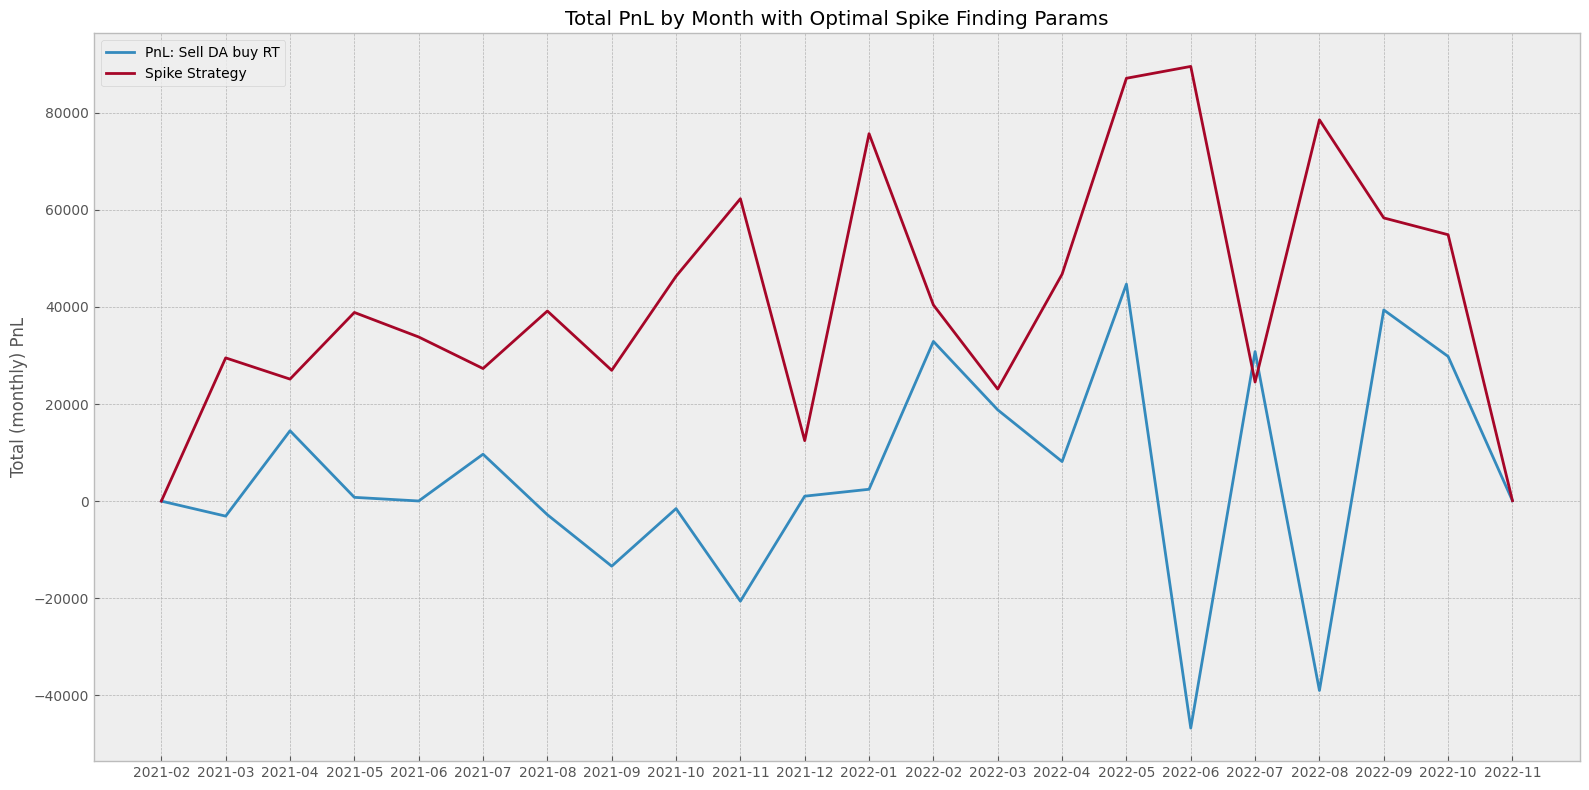

In [168]:
#plot the two PnLs against each other
df_month.reset_index(inplace=True)
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)

pnl1,=plt.plot(df_month['MONTH'].astype(str), df_month['PnL: Sell DA'], label='PnL: Sell DA buy RT')
pnl2,=plt.plot(df_month['MONTH'].astype(str), df_month['PnL: Spike'], label='Spike Strategy')


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Total PnL by Month with Optimal Spike Finding Params")
ax.set_ylabel("Total (monthly) PnL")

#res.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

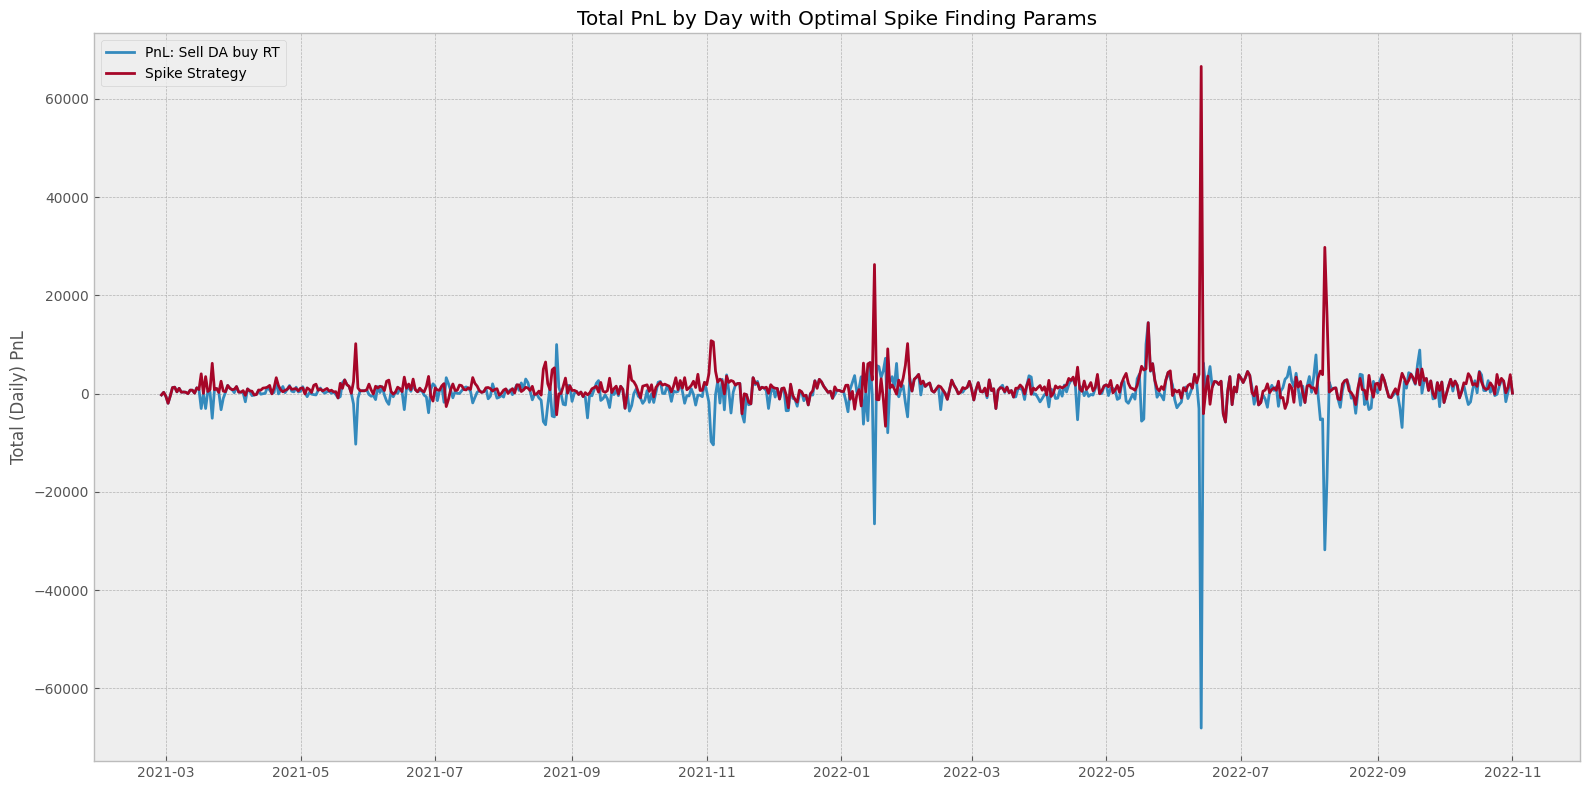

In [170]:
#plot the two PnLs against each other
df_daily.reset_index(inplace=True)
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)

pnl1,=plt.plot(df_daily['DATE'], df_daily['PnL: Sell DA'], label='PnL: Sell DA buy RT')
pnl2,=plt.plot(df_daily['DATE'], df_daily['PnL: Spike'], label='Spike Strategy')


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Total PnL by Day with Optimal Spike Finding Params")
ax.set_ylabel("Total (Daily) PnL")

#res.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\2514765232.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (df_daily['DATE'] > pd.to_datetime('2022-06-01')) & (df_daily['DATE'] <= pd.to_datetime('2022-07-01'))


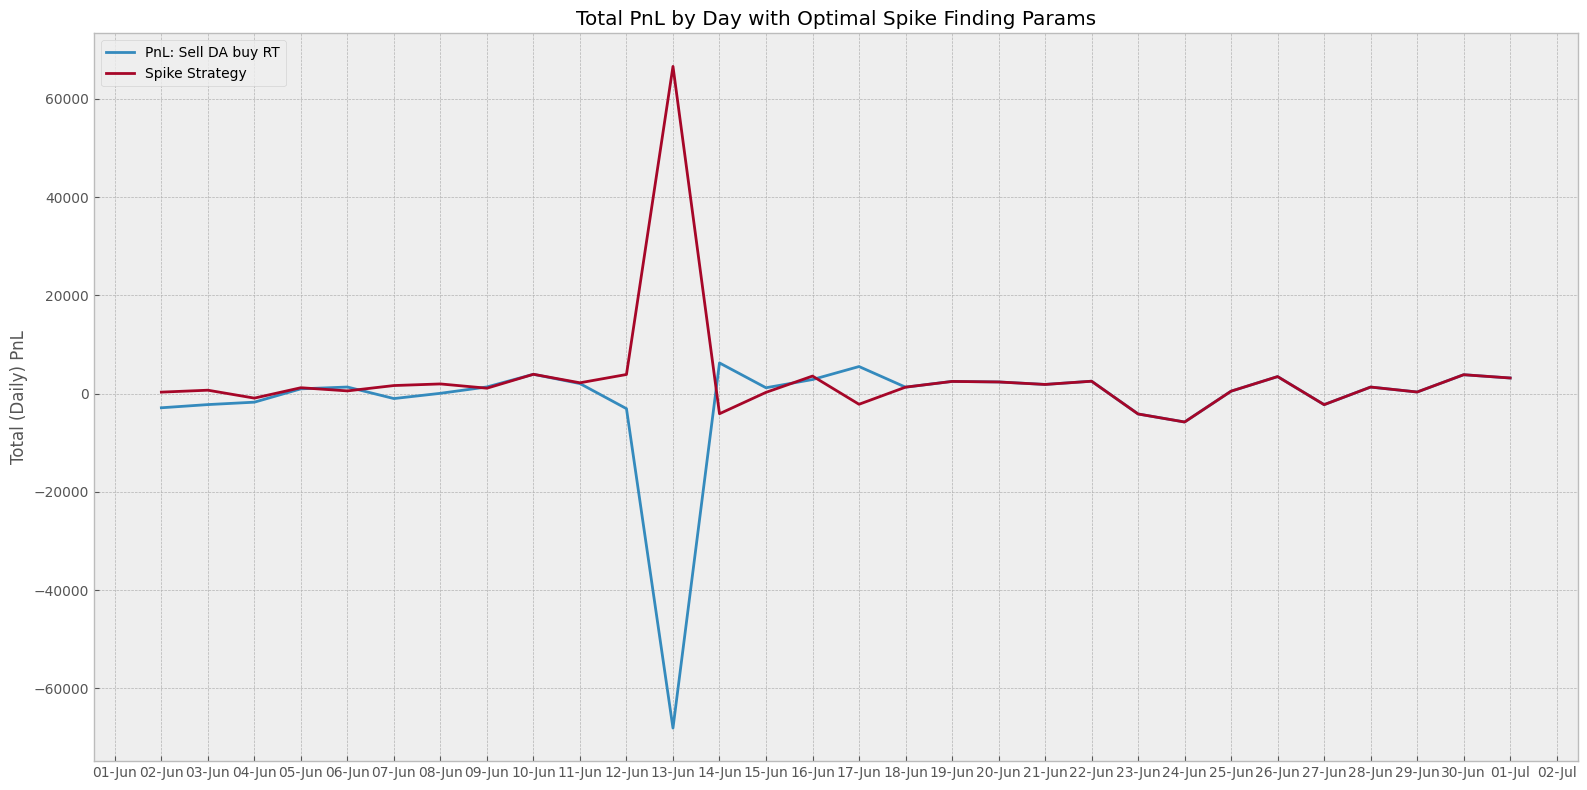

In [171]:
#zoomed in on June of 2022
mask = (df_daily['DATE'] > pd.to_datetime('2022-06-01')) & (df_daily['DATE'] <= pd.to_datetime('2022-07-01'))
df_daily_J = df_daily.loc[mask]

plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)

pnl1,=plt.plot(df_daily_J['DATE'], df_daily_J['PnL: Sell DA'], label='PnL: Sell DA buy RT')
pnl2,=plt.plot(df_daily_J['DATE'], df_daily_J['PnL: Spike'], label='Spike Strategy')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Total PnL by Day with Optimal Spike Finding Params")
ax.set_ylabel("Total (Daily) PnL")

#res.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\3780634192.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (df['DATE'] > pd.to_datetime('2022-06-12')) & (df['DATE'] <= pd.to_datetime('2022-06-13'))


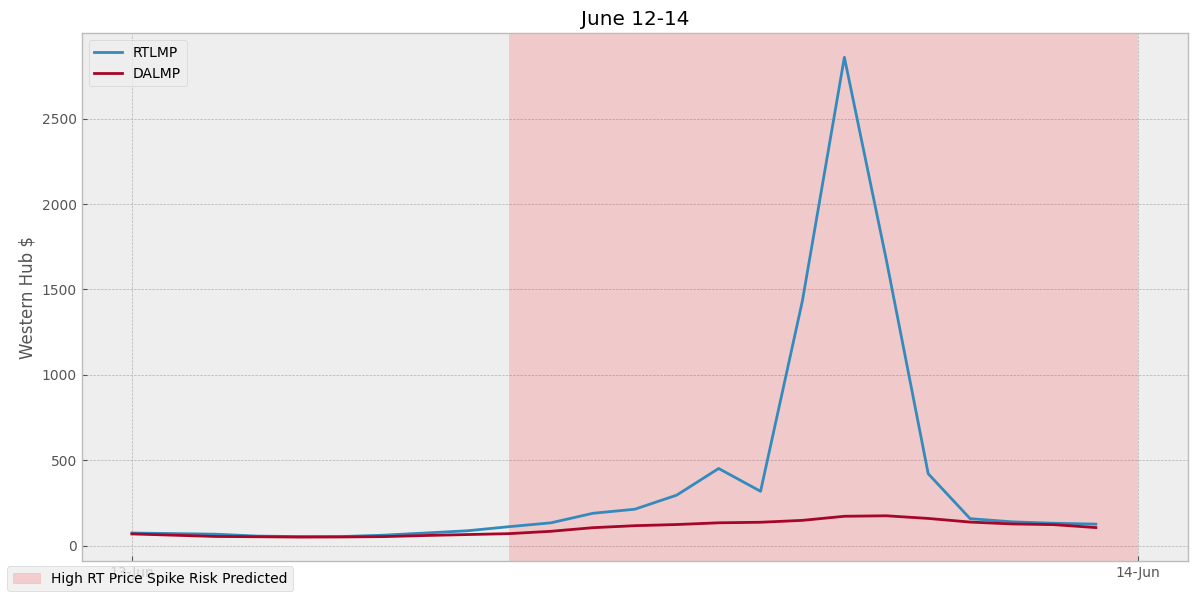

In [172]:
#Plot DALMP and RTLMP for June 13-14 as well as predicted spikes
plt.style.use('bmh')
df['DATETIME']=pd.to_datetime(df['DATETIME'])
fig, ax = plt.subplots(figsize = (12, 6),tight_layout=True)
mask = (df['DATE'] > pd.to_datetime('2022-06-12')) & (df['DATE'] <= pd.to_datetime('2022-06-13'))
df_hourly_J = df.loc[mask]


rtlmp,=plt.plot(df_hourly_J['DATETIME'], df_hourly_J['RTLMP'], label='RTLMP')
dalmp,=plt.plot(df_hourly_J['DATETIME'], df_hourly_J['DALMP'], label='DALMP')


ax.xaxis.set_major_locator(md.DayLocator())
ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("June 12-14")
ax.set_ylabel("Western Hub $")

df_hourly_J.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[rtlmp,dalmp],loc='upper left')
plt.show()


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


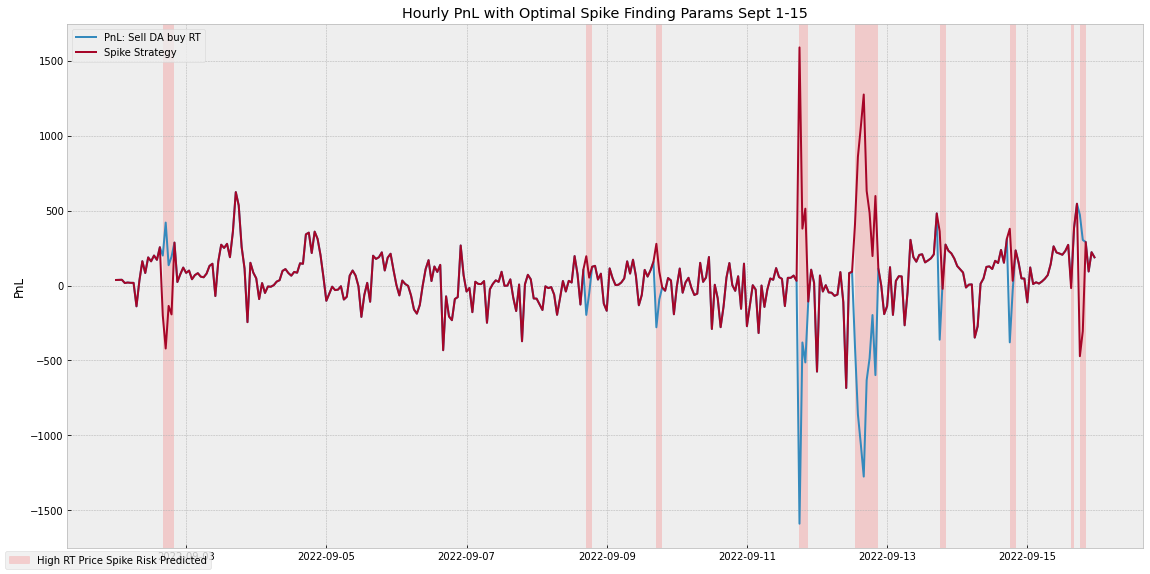

In [ ]:
mask = (df['DATE'] > pd.to_datetime('2022-09-01')) & (df['DATE'] <= pd.to_datetime('2022-09-15'))
df_hourly_S = df.loc[mask]

plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)

pnl1,=plt.plot(df_hourly_S['DATETIME'], df_hourly_S['PnL: Sell DA'], label='PnL: Sell DA buy RT')
pnl2,=plt.plot(df_hourly_S['DATETIME'], df_hourly_S['PnL: Spike'], label='Spike Strategy')


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Hourly PnL with Optimal Spike Finding Params Sept 1-15")
ax.set_ylabel("PnL")

df_hourly_S.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


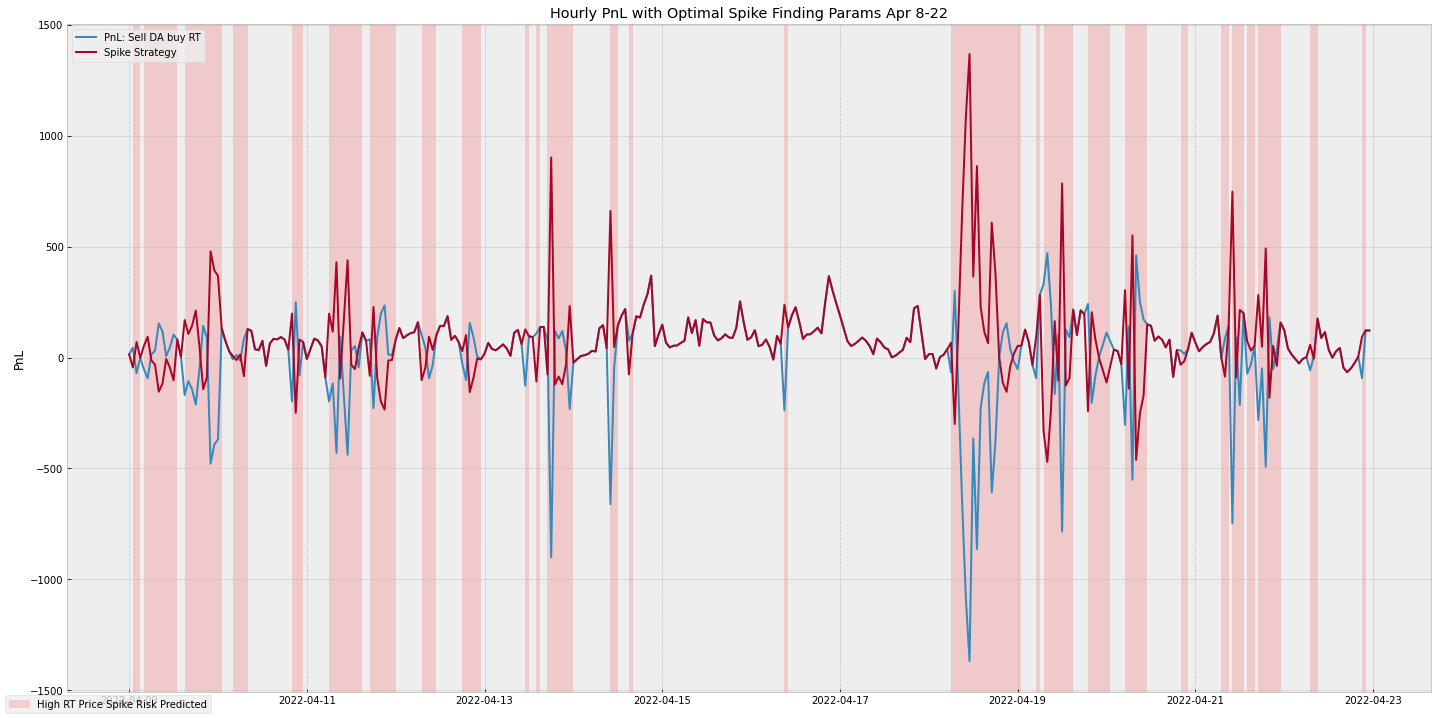

In [ ]:
mask = (df['DATE'] > pd.to_datetime('2022-04-08')) & (df['DATE'] <= pd.to_datetime('2022-04-22'))
df_hourly_A = df.loc[mask]

plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (20, 10),tight_layout=True)

pnl1,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Sell DA'], label='PnL: Sell DA buy RT')
pnl2,=plt.plot(df_hourly_A['DATETIME'], df_hourly_A['PnL: Spike'], label='Spike Strategy')


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Hourly PnL with Optimal Spike Finding Params Apr 8-22")
ax.set_ylabel("PnL")

df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
fig.legend(handles=[red_patch], loc='lower left')
ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

In [174]:
#Percent of hours that PnL Spike is greater then dummy PnL
df['COUNT']=1
df['USE']=np.where((df['PnL: Spike']> df['PnL: Sell DA']),1, 0)
df['WIN']=np.where((df['PEAK']==df['Spikes']), 1, 0)
df['DATE']= pd.to_datetime(df['DATETIME']).dt.date
df['MONTH'] = pd.to_datetime(df['DATE']).dt.to_period('M')
df_month=df.groupby('MONTH').sum()
df_month['PERCENT USE']=df_month['USE']/df_month['COUNT']*100
df_month['PERCENT WIN']=df_month['WIN']/df_month['COUNT']*100
df_month

C:\Users\katvo\AppData\Local\Temp\ipykernel_11064\2945412374.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month=df.groupby('MONTH').sum()


,DALMP,RTLMP,PEAK,Spikes,PnL: Sell DA,PnL: Sell RT,PnL: Spike,COUNT,USE,WIN,PERCENT USE,PERCENT WIN
MONTH,,,,,,,,,,,,
2021-02,925.810793,925.164103,-45,-46,6.46690,9251.64103,6.46690,46,0,45,0.000000,97.826087
2021-03,18263.173100,18571.758487,-27,-141,-3085.85387,185717.58487,29509.46633,734,20,617,2.724796,84.059946
2021-04,19190.423902,17740.598441,15,53,14498.25461,177405.98441,25137.80971,710,59,588,8.309859,82.816901
2021-05,20584.328035,20505.998255,-51,-41,783.29780,205059.98255,38866.30228,733,64,607,8.731241,82.810368
2021-06,21968.944312,21965.561246,-8,12,33.83066,219655.61246,33812.94658,710,68,610,9.577465,85.915493
2021-07,26980.217677,26013.630426,-74,39,9665.87251,260136.30426,27314.56947,734,75,603,10.217984,82.152589
2021-08,32062.863055,32342.357085,-43,33,-2794.94030,323423.57085,39162.78252,734,92,622,12.534060,84.741144
2021-09,32241.481988,33580.685372,-99,-60,-13392.03384,335806.85372,26945.28642,710,76,581,10.704225,81.830986
2021-10,43557.335530,43710.817581,-25,-11,-1534.82051,437108.17581,46318.89867,733,97,623,13.233288,84.993179


In [ ]:
#Plot lag vs PnL for a single test
# we will need: load data, scoring func, optuna trials, vary only lag
def my_scoring_func_2(data,Lag, Threshold, Influence, base='2022-01-01'):
  '''Function call obtains resulting PnL for DA selling and spike methods'''
  start_dt='2022-04-01'
  end_dt='2022-06-01'
  res=pnl_test_get_res(data,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, Vol=10)
  #return res['PnL: Spike'].sum()
  return res['PnL: Spike'].sum(), res['PnL: Sell DA'].sum()

#run some YTD tests
pd.options.mode.chained_assignment = None  # default='warn'

def objective3(trial):
    Lag = trial.suggest_int("Lag", 24, 24*7*6, step=6)
    #Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    Threshold=0.5
    #Influence = trial.suggest_float("Influence", 0.0, 1.0)
    Influence=0.5
    pnl_spike_sum, pnl_sell_da_sum = my_scoring_func_2(data,Lag, Threshold, Influence)
    trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective3, n_trials=100, n_jobs=-1)


[I 2022-10-31 17:30:54,561] A new study created in memory with name: no-name-c118118d-8214-4e4f-9b00-d6d860aed3f5
[I 2022-10-31 17:31:05,121] Trial 0 finished with value: 8700.50696 and parameters: {'Lag': 306, 'PnL: Sell DA': 9014.471119999998}. Best is trial 0 with value: 8700.50696.
[I 2022-10-31 17:31:05,139] Trial 1 finished with value: 9066.508020000001 and parameters: {'Lag': 144, 'PnL: Sell DA': 9014.471119999998}. Best is trial 1 with value: 9066.508020000001.
[I 2022-10-31 17:31:14,143] Trial 3 finished with value: 7677.05238 and parameters: {'Lag': 618, 'PnL: Sell DA': 9014.471119999998}. Best is trial 1 with value: 9066.508020000001.
[I 2022-10-31 17:31:15,022] Trial 2 finished with value: 8866.53398 and parameters: {'Lag': 510, 'PnL: Sell DA': 9014.471119999998}. Best is trial 1 with value: 9066.508020000001.
[I 2022-10-31 17:31:23,288] Trial 4 finished with value: 8866.53398 and parameters: {'Lag': 552, 'PnL: Sell DA': 9014.471119999998}. Best is trial 1 with value: 9066.

In [ ]:
test_lag= study.trials_dataframe().sort_values(by='params_Lag').groupby('params_Lag').mean().reset_index()

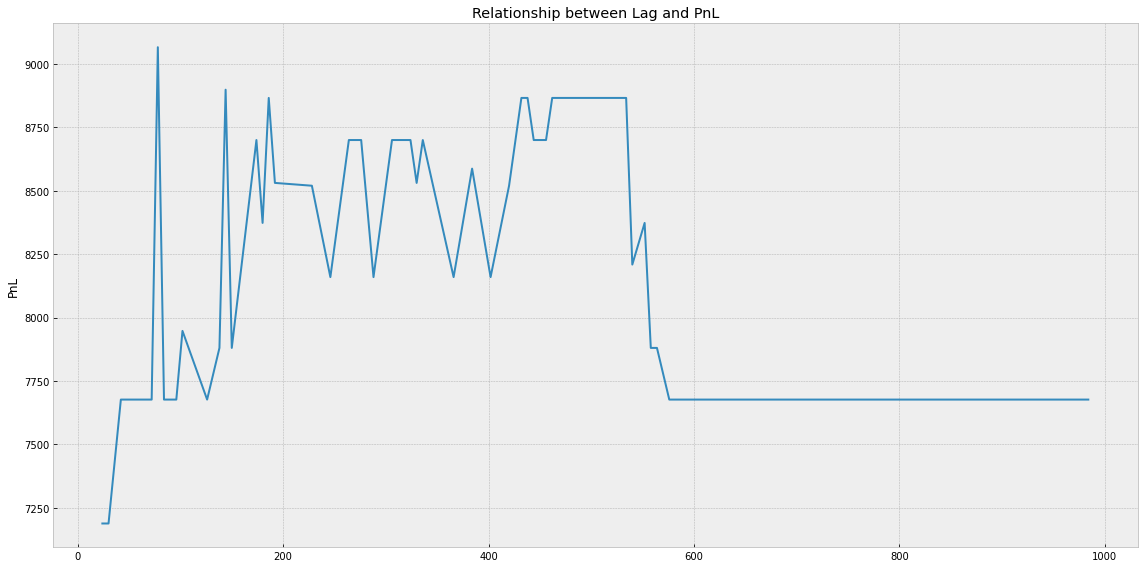

In [ ]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)


rel=plt.plot(test_lag['params_Lag'], test_lag['value'])


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Relationship between Lag and PnL")
ax.set_ylabel("PnL")

#df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
#ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

In [ ]:
def my_scoring_func_2(data,Lag, Threshold, Influence, base='2022-01-01'):
  '''Function call obtains resulting PnL for DA selling and spike methods'''
  start_dt='2022-06-01'
  end_dt='2022-08-01'
  res=pnl_test_get_res(data,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, Vol=10)
  #return res['PnL: Spike'].sum()
  return res['PnL: Spike'].sum(), res['PnL: Sell DA'].sum()

#run some YTD tests
pd.options.mode.chained_assignment = None  # default='warn'

def objective3(trial):
    Lag = trial.suggest_int("Lag", 24, 24*7*6, step=6)
    #Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    Threshold=0.5
    #Influence = trial.suggest_float("Influence", 0.0, 1.0)
    Influence=0.5
    pnl_spike_sum, pnl_sell_da_sum = my_scoring_func_2(data,Lag, Threshold, Influence)
    trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective3, n_trials=100, n_jobs=-1)


[I 2022-10-31 17:40:51,614] A new study created in memory with name: no-name-5b4ff7ee-94c6-4d8d-b85a-600595938a7d
[I 2022-10-31 17:41:04,043] Trial 0 finished with value: 1373.6018400000007 and parameters: {'Lag': 690, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 0 with value: 1373.6018400000007.
[I 2022-10-31 17:41:04,124] Trial 1 finished with value: 1373.6018400000007 and parameters: {'Lag': 606, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 0 with value: 1373.6018400000007.
[I 2022-10-31 17:41:12,602] Trial 2 finished with value: 4072.8598199999997 and parameters: {'Lag': 522, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 2 with value: 4072.8598199999997.
[I 2022-10-31 17:41:14,515] Trial 3 finished with value: 1803.6316399999998 and parameters: {'Lag': 180, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 2 with value: 4072.8598199999997.
[I 2022-10-31 17:41:20,909] Trial 4 finished with value: 1373.6018400000007 and parameters: {'Lag': 786, 'PnL: Sell DA': 1373.

In [ ]:
test_lag= study.trials_dataframe().sort_values(by='params_Lag').groupby('params_Lag').mean().reset_index()

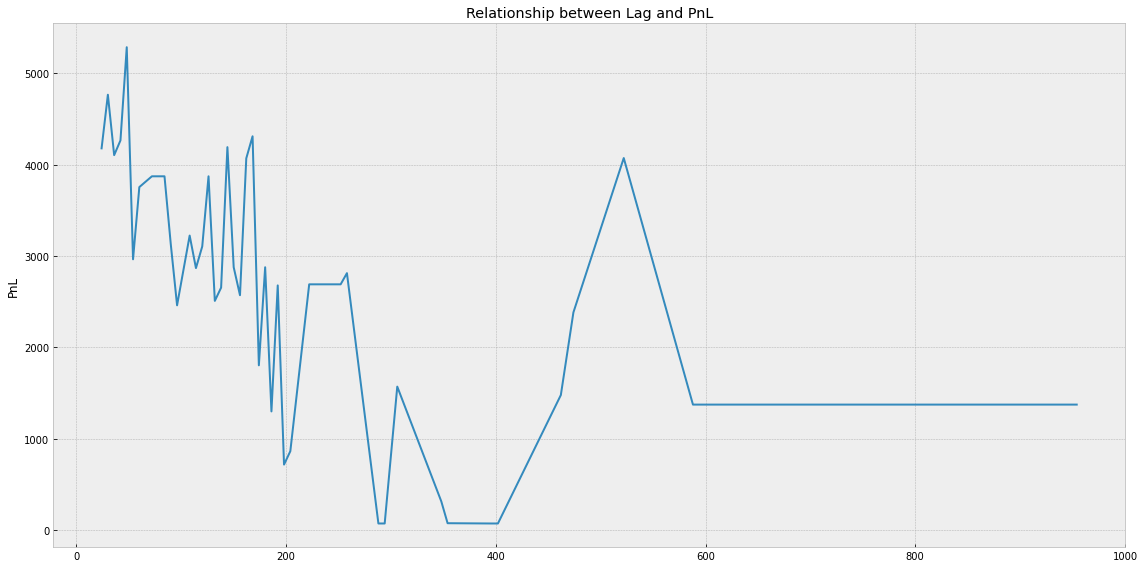

In [ ]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (16, 8),tight_layout=True)


rel=plt.plot(test_lag['params_Lag'], test_lag['value'])


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Relationship between Lag and PnL")
ax.set_ylabel("PnL")

#df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
#ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()

In [ ]:
def my_scoring_func_2(data,Lag, Threshold, Influence, base='2022-01-01'):
  '''Function call obtains resulting PnL for DA selling and spike methods'''
  start_dt='2022-06-01'
  end_dt='2022-08-01'
  res=pnl_test_get_res(data,Lag, Threshold, Influence,start_date=start_dt, end_date=end_dt, Vol=10)
  #return res['PnL: Spike'].sum()
  return res['PnL: Spike'].sum(), res['PnL: Sell DA'].sum()

#run some YTD tests
pd.options.mode.chained_assignment = None  # default='warn'

def objective3(trial):
    #Lag = trial.suggest_int("Lag", 24, 24*7*6, step=6)
    Lag=500
    Threshold=trial.suggest_float("Threshold", 0.5, 7.5, step=0.5)
    #Threshold=0.5
    #Influence = trial.suggest_float("Influence", 0.0, 1.0)
    Influence=0.5
    pnl_spike_sum, pnl_sell_da_sum = my_scoring_func_2(data,Lag, Threshold, Influence)
    trial.suggest_categorical("PnL: Sell DA", choices=[pnl_sell_da_sum])
    #trial.set_user_attr("PnL: Sell DA", pnl_sell_da_sum)
    return pnl_spike_sum

study = optuna.create_study(direction="maximize",
                           sampler=optuna.samplers.TPESampler(),
                          pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective3, n_trials=100, n_jobs=-1)

[I 2022-10-31 18:15:29,306] A new study created in memory with name: no-name-f256ffea-1903-434f-8983-8e6214ce8616
[I 2022-10-31 18:15:39,778] Trial 1 finished with value: 1373.6018400000007 and parameters: {'Threshold': 4.0, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 1 with value: 1373.6018400000007.
[I 2022-10-31 18:15:44,007] Trial 0 finished with value: 1373.6018400000007 and parameters: {'Threshold': 1.0, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 1 with value: 1373.6018400000007.
[I 2022-10-31 18:15:47,727] Trial 2 finished with value: 1373.6018400000007 and parameters: {'Threshold': 5.5, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 1 with value: 1373.6018400000007.
[I 2022-10-31 18:15:50,889] Trial 3 finished with value: 1373.6018400000007 and parameters: {'Threshold': 6.5, 'PnL: Sell DA': 1373.6018400000007}. Best is trial 1 with value: 1373.6018400000007.
[I 2022-10-31 18:15:54,117] Trial 4 finished with value: 1373.6018400000007 and parameters: {'Threshol

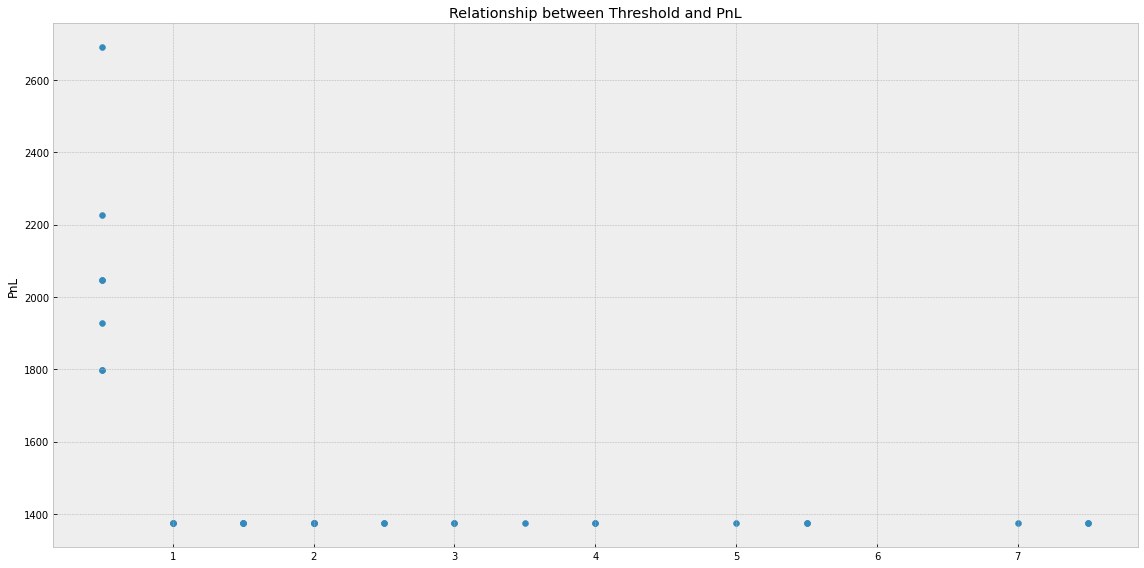

In [ ]:
#test_lag= study.trials_dataframe().sort_values(by='params_Threshold').groupby('params_Threshold').mean().reset_index()
test_lag=study.trials_dataframe()
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12, 6),tight_layout=True)


rel=plt.scatter(test_lag['params_Threshold'], test_lag['value'])


#ax.xaxis.set_major_locator(md.DayLocator())
#ax.xaxis.set_major_formatter(md.DateFormatter('%d-%b'))
ax.set_title("Relationship between Threshold and PnL")
ax.set_ylabel("PnL")

#df_hourly_A.apply(lambda row: plot_fill(row['DATETIME'], row['Spikes']), axis=1)
#red_patch = mpatches.Patch(color='red',alpha=0.15, label='High RT Price Spike Risk Predicted')
#fig.legend(handles=[red_patch], loc='lower left')
#ax.legend(handles=[pnl1,pnl2],loc='upper left')
plt.show()